In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:  
  print(gpu_info)

Sun Mar 28 15:36:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
%%capture
!pip3 install transformers==3.0.2 
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb
!pip3 install rouge-score tqdm
!pip3 install rouge

In [1]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import copy
import os

from collections import defaultdict, OrderedDict
from sklearn.base import BaseEstimator, TransformerMixin
#import progressbar
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
#import dill
import tarfile
import json, gzip
import math
from typing import Optional, Union, Iterable, NamedTuple, Dict, List

#!pip install transformers==3.0.2 -qq

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from rouge import Rouge
from rouge_score import rouge_scorer, scoring

import wandb


from transformers.modeling_t5 import T5Stack, T5LayerCrossAttention, T5Block, T5Attention

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed():
    SEED = 123
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
set_seed()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Setting the environment**

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final-T5.ipynb'

In [4]:
!cp '/root/optimizers.py' '/root/Projects/' # SSH
!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .
from optimizers import AdaFactor

In [5]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


## Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading dataset and unzip**

In [ ]:
fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

tar = tarfile.open(fname, "r:")
tar.extractall()
tar.close()

In [ ]:
!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'
!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [ ]:
#path = '/home/jupyter/' # For GCp
path = '/root/release/' # For SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # For Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
testset = read_data(path, 'test')

In [ ]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
test_data = get_data(testset)

In [ ]:
train_data.head()

In [ ]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

In [ ]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [ ]:
train_data.isna().sum(), valid_data.isna().sum()

**Preprocessing**

In [ ]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [ ]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)
    
    if self.max_length is not None:
        min_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, min_len

In [ ]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [ ]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

In [ ]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

**Saving preprocessed data**

In [ ]:
train_processed.to_pickle("./train_processed.pkl")

In [ ]:
valid_processed.to_pickle("./valid_processed.pkl")

In [ ]:
train_processed.info()

Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

**Loading pre-processed data**

In [6]:
train_processed = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/train_processed.pkl")
valid_processed = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/valid_processed.pkl")
# valid_processed = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/test_processed.pkl", compression='zip')

In [7]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)

inds = np.where(valid_processed['summary_len'] < 10)
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

# indds = np.where(test_processed['summary_len'] < 10)
# test_processed_data = test_processed.drop(indds[0])
# test_processed_data = test_processed_data.reset_index(drop=True)

In [ ]:
train_processed_data.info()

In [ ]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [ ]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [ ]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [ ]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [ ]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [ ]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [8]:
art = 700 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 250# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:700, sum len:250


In [9]:
artV = 700 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 250# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:700, sum len:250


#### Creating Custom Dataset

In [10]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [11]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [12]:
def training(model, dataset_loader, optimizer,log_interval,regularizer, LEARNING_RATE, eps_sched=None, batchs=None,epoch=0, use_wandb=True):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'\nStart training for epoch: {epoch}')
    
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, labels=langm_labels, lambd=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs
        
        # Before next loop: anneal optimizer variables 
        
        if eps_sched is not None and  batchs is not None:
            itr = epoch*(len(dataset_loader.dataset)//batchs) + idx
            optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if use_wandb and idx%log_interval == 0:
            wandb.log({"Training Loss": loss.item()})
        else:
            if idx % 5000 == 0:
                print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
   

        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem

    directory = '/content/drive/MyDrive/Colab Notebooks'
    PATH = os.path.join(directory, f'independent_final_model_reg0.1.pth')
    saving(PATH, epoch, optimizer, model, LEARNING_RATE)
  
    return avg_loss, output


In [13]:
def validation(model, dataset_loader, regularizer, token_summaries=False):
    model.eval()

    eval_loss = 0
    nItem = 0
    droped = 0
    open_gates = 0
    total_doc_tokens = 0
    tokens_info = None

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, labels=langm_labels, lambd=regularizer)

            loss = output[0]
            
            if token_summaries:                
                droped_number, nbr_of_nonzero_gates, total_tokens = output[-2] 
                droped += droped_number
                open_gates += nbr_of_nonzero_gates
                total_doc_tokens += total_tokens

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem
    
    if token_summaries:
        tokens_info = (droped, open_gates, total_doc_tokens)

    return eval_loss, tokens_info, output[-1] 

In [14]:
def saving(PATH, epoch, optm, model, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optm.state_dict(),
            'learning_rate': LEARNING_RATE
            }, PATH)

#### Getting samples of data

In [15]:
#@title Train, Validation and Test splits { run: "auto" }
set_seed()

columns = ["text","summary"]


X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
indices = np.random.permutation(len(X_train))
ind = indices[:150000]
Xtrain_trial = X_train.iloc[ind]
Xtrain_trial = Xtrain_trial.reset_index(drop=True)

X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)
valind = np.random.permutation(len(X_valid))
vind = valind[:6000]
Xvalid_trial = X_valid.iloc[valind]
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

# X_test = test_processed_data[columns]
# testind = np.random.permutation(len(X_test))
# tind = testind[:6000]
# Xtest_trial = X_test.iloc[tind]
# Xtest_trial = Xtest_trial.reset_index(drop=True)

# Xtest_trial.head()
# Xtrain_trial.head()

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [16]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [17]:
#@title Parameters form fields
#@markdown Forms support many types of fields.

reg = 0.1 #@param {type:"number"}
LEARNING_RATE = 0.000355 #@param {type:"slider", min:0.0001, max:0.000655, step:0.000155}
num_threshold = 0.003 #@param {type: "number"}
MODEL_NAME = "t5-base" #@param ["t5-3b", "t5-base", "t5-large", "t5-11b"]
#@markdown ---


In [18]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }
# or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [19]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, config ):
    super(GatedFilterLayer, self).__init__()

    self.d_model = config.d_model
    self.projector = nn.Linear(self.d_model, 1,bias=False)

  def forward(self, last_hidden_encoder):
    
    proj = self.projector(last_hidden_encoder) # (bs, seqlen,1)
    proj = proj.unsqueeze(1) # (bs,1,seqlen,1)
    gate = torch.sigmoid(proj) # (bs,1,seqlen,1)

    return gate 

In [20]:
class EncoderStack(T5Stack):

  def __init__(self,config, embed_tokens=None):
    super().__init__(config)

    self.embed_tokens = embed_tokens 
    self.is_decoder = config.is_decoder
    self.config = config
    self.gatefilter = GatedFilterLayer(config)

  def forward(self, 
              input_ids=None,
              attention_mask=None,
              encoder_hidden_states=None,
              encoder_attention_mask=None,
              inputs_embeds=None,
              head_mask=None,
              past_key_value_states=None,
              use_cache=False,
              output_attentions=None,
              output_hidden_states=None,
          ):
    
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            if self.is_decoder:
                raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")
            else:
                raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to intialize the model with valid token embeddings"
            inputs_embeds = self.embed_tokens(input_ids)

        batch_size, seq_length = input_shape

        if past_key_value_states is not None:
            assert seq_length == 1, "Input shape is {}, but should be {} when using past_key_value_sates".format(
                input_shape, (batch_size, 1)
            )
            # required mask seq length can be calculated via length of past
            # key value states and seq_length = 1 for the last token
            mask_seq_length = past_key_value_states[0][0].shape[2] + seq_length
        else:
            mask_seq_length = seq_length

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length).to(inputs_embeds.device)
        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_value_states with `None` if past does not exist
        if past_key_value_states is None:
            past_key_value_states = [None] * len(self.block)

        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape, inputs_embeds.device)

        if self.is_decoder and encoder_attention_mask is not None:
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        present_key_value_states = ()
        all_hidden_states = ()
        all_attentions = ()
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value_state) in enumerate(zip(self.block, past_key_value_states)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                head_mask=head_mask[i],
                past_key_value_state=past_key_value_state,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
            hidden_states, present_key_value_state = layer_outputs[:2]

            if i == 0:
                # We share the position biases between the layers - the first layer store them
                # layer_outputs = hidden-states, key-value-states (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
                position_bias = layer_outputs[3 if output_attentions else 2]
                if self.is_decoder and encoder_hidden_states is not None:
                    encoder_decoder_position_bias = layer_outputs[5 if output_attentions else 3]
            # append next layer key value states
            present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[2],)  # We keep only self-attention weights for now

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)
        
        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if use_cache is True:
            assert self.is_decoder, "`use_cache` can only be set to `True` if {} is used as a decoder".format(self)
            outputs = outputs + (present_key_value_states,)
        if output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if output_attentions:
            outputs = outputs + (all_attentions,)

        # Defining gates

        last_hidden_state = outputs[0]
        gates = self.gatefilter(last_hidden_state)
        outputs = outputs + (gates,)

        return outputs  # last-layer hidden state, (presents,) (all hidden states), (all attentions), (gates,)

In [21]:

def softmax(scores, gates, smoothness=1e-9):

  scores_max = torch.max(scores,dim=-1)[0].unsqueeze(-1)
  scores = scores - scores_max
  A = torch.exp(scores) # (bs, n_heads, qlen, klen)
  gates= gates.permute(0,1,3,2) # (bs, n_heads,1, klen)
  A_g = gates * A
  sum_norm = torch.sum(A_g,axis=-1).unsqueeze(-1)

  # sum_norm = 1/torch.sum(A_g,axis=-1).unsqueeze(-1)
  # if torch.any(sum_norm.isnan())==True:
  #   mask_nan = sum_norm != sum_norm
  #   mask_nan = ~mask_nan
  #   smoothing_tensor = torch.full(mask_nan.shape, smoothness).type_as(sum_norm)
  #   sum_norm = torch.where(mask_nan, sum_norm, smoothing_tensor)#.type_as(sum_norm)
  
  weights = A_g/sum_norm
  return weights

In [22]:
class T5GatedAtention(T5Attention):
  r"""
  The source code is from huggingface. For more details, check their github 
  @https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_t5.py#L204
  
  Retuns:
    Context, attentions weights on the keys for the provided queries  
  """

  def __init__(self, config, has_relative_attention_bias = False): 
    super(T5GatedAtention, self).__init__(config)

    self.has_relative_attention_bias = has_relative_attention_bias 
    self.relative_attention_num_buckets = config.relative_attention_num_buckets
    self.config = config
    self.config.is_decoder = True
    self.n_heads = config.num_heads

    if self.has_relative_attention_bias:
        self.relative_attention_bias = nn.Embedding(self.relative_attention_num_buckets, self.n_heads)
  
  def forward(
        self,
        input,
        gates,
        mask=None,
        kv=None,
        position_bias=None,
        past_key_value_state=None,
        head_mask=None,
        query_length=None,
        use_cache=True,
        output_attentions=False,
        speed_up = False,
    ):
        """
        Self-attention (if kv is None) or attention over source sentence (provided by kv).
        """
        # Input is (bs, qlen, dim)
        # Mask is (bs, klen) (non-causal) or (bs, klen, klen)
        # past_key_value_state[0] is (bs, n_heads, q_len - 1, dim_per_head)
        bs, qlen, dim = input.size()

        if past_key_value_state is not None:
            assert self.config.is_decoder is True, "Encoder cannot cache past key value states"
            assert (
                len(past_key_value_state) == 2
            ), "past_key_value_state should have 2 past states: keys and values. Got {} past states".format(
                len(past_key_value_state)
            )
            real_qlen = qlen + past_key_value_state[0].shape[2] if query_length is None else query_length
        else:
            real_qlen = qlen

        if kv is None:
            klen = real_qlen
        else:
            klen = kv.size(1)

        def shape(x):
            """  projection """
            return x.view(bs, -1, self.n_heads, self.d_kv).transpose(1, 2)

        def unshape(x):
            """  compute context """
            return x.transpose(1, 2).contiguous().view(bs, -1, self.inner_dim)

        q = shape(self.q(input))  # (bs, n_heads, qlen, dim_per_head)

        if kv is None:
            k = shape(self.k(input))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v(input))  # (bs, n_heads, qlen, dim_per_head)

        elif past_key_value_state is None:
            k = v = kv
            k = shape(self.k(k))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v(v))  # (bs, n_heads, qlen, dim_per_head)

        if past_key_value_state is not None:
            if kv is None:
                k_, v_ = past_key_value_state
                k = torch.cat([k_, k], dim=2)  # (bs, n_heads, klen, dim_per_head)
                v = torch.cat([v_, v], dim=2)  # (bs, n_heads, klen, dim_per_head)
            else:
                k, v = past_key_value_state

        if self.config.is_decoder and use_cache is True:
            present_key_value_state = ((k, v),)
        else:
            present_key_value_state = (None,)

        # For evaluation remove irrelevant info if we want to
        if not self.training:
            if speed_up is True:
                gates, gate_mask, enc_ids, _ = gates
            else:
                gates, gate_mask, _ = gates
                
            # k = k * gate_mask
            # v = v * gate_mask

        k = k * gates
        v = v * gates

        scores = torch.einsum("bnqd,bnkd->bnqk", q, k)  # (bs, n_heads, qlen, klen)

        if position_bias is None:
            if not self.has_relative_attention_bias:
                raise ValueError("No position_bias provided and no weights to compute position_bias")
            position_bias = self.compute_bias(real_qlen, klen)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value_state is not None:
                position_bias = position_bias[:, :, -1:, :]

            if mask is not None:
                if speed_up is True:
                    if enc_ids is not None: # catch for no ids to extract
                        mask = mask[:,:,:,enc_ids]
                position_bias = position_bias + mask  # (bs, n_heads, qlen, klen)

        scores += position_bias

        #if gate_filter_output is not None:
        bsk, n_headsk, klenk, _ = k.size()
        bsg, _, kleng, _ = gates.size()
        
        error_message = "Shapes missmatch. There should be gates of shape {}. Got {}".format(k.shape,gates.shape)
        assert (bsg, kleng) == (bsk, klenk), error_message

        # if self.training:
        
        weights = F.softmax(scores.float()).type_as(scores)  # (bs, n_heads, qlen, klen)
        
        # else:
        # weights = softmax(scores.float(), gates=gates).type_as(scores)  # (bs, n_heads, qlen, klen)
        
        # gates = gates.permute(0,1,3,2) # (bs, 1,1, klen),
        # weights = weights * gates

        weights = F.dropout(weights, p=self.dropout, training=self.training)  # (bs, n_heads, qlen, klen)
        # Mask heads if we want to
        if head_mask is not None:
            weights = weights * head_mask

        context = torch.matmul(weights, v)  # (bs, n_heads, qlen, dim_per_head)
        context = unshape(context)  # (bs, qlen, dim)
        context = self.o(context)

        outputs = (context,) + present_key_value_state 

        if output_attentions: 
            outputs = outputs + (weights,)
        if self.has_relative_attention_bias:
            outputs = outputs + (position_bias,)                
        return outputs


In [23]:
class T5LayerGatedCrossAttention(T5LayerCrossAttention):

  def __init__(self, config, has_relative_attention_bias=False):
        super().__init__(config)

        self.EncDecAttention = T5GatedAtention(config, has_relative_attention_bias)

  def forward(
      self,
      hidden_states,
      gates,
      kv,
      attention_mask=None,
      position_bias=None,
      head_mask=None,
      past_key_value_state=None,
      use_cache=True,
      query_length=None,
      output_attentions=False,
      speed_up = False,
  ):
      norm_x = self.layer_norm(hidden_states)
      attention_output = self.EncDecAttention(
          norm_x,
          gates = gates,
          mask=attention_mask,
          kv=kv,
          position_bias=position_bias,
          head_mask=head_mask,
          past_key_value_state=past_key_value_state,
          use_cache=use_cache,
          query_length=query_length,
          output_attentions=output_attentions,
          speed_up = speed_up,
      )
      y = attention_output[0]
      layer_output = hidden_states + self.dropout(y)
      outputs = (layer_output,) + attention_output[1:]  # add attentions if we output them
      return outputs


In [24]:
class GatedT5Block(T5Block):

  def __init__(self,config,DecodBlock):
    super(GatedT5Block, self).__init__(config)

    self.config = config
    self.layer = DecodBlock.layer

  def forward(
      self,
      hidden_states,
      gates,
      attention_mask=None,
      position_bias=None,
      encoder_hidden_states=None,
      encoder_attention_mask=None,
      encoder_decoder_position_bias=None,
      head_mask=None,
      past_key_value_state=None,
      use_cache=True,
      output_attentions=False,
      speed_up = False,
  ):

      if past_key_value_state is not None:
          assert self.config.is_decoder, "Only decoder can use `past_key_value_states`"
          expected_num_past_key_value_states = 2 if encoder_hidden_states is None else 4

          error_message = "There should be {} past states. 2 (past / key) for self attention.{} Got {} past key / value states".format(
              expected_num_past_key_value_states,
              "2 (past / key) for cross attention" if expected_num_past_key_value_states == 4 else "",
              len(past_key_value_state),
          )
          assert len(past_key_value_state) == expected_num_past_key_value_states, error_message

          self_attn_past_key_value_state = past_key_value_state[:2]
          cross_attn_past_key_value_state = past_key_value_state[2:]
      else:
          self_attn_past_key_value_state, cross_attn_past_key_value_state = None, None


      self_attention_outputs = self.layer[0](
          hidden_states,
          attention_mask=attention_mask,
          position_bias=position_bias,
          head_mask=head_mask,
          past_key_value_state=self_attn_past_key_value_state,
          use_cache=use_cache,
          output_attentions=output_attentions,
      )
      hidden_states, present_key_value_state = self_attention_outputs[:2]
      attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights


      if self.config.is_decoder and encoder_hidden_states is not None:
          # the actual query length is unknown for cross attention
          # if using past key value states. Need to inject it here
          if present_key_value_state is not None:
              query_length = present_key_value_state[0].shape[2]
          else:
              query_length = None

          cross_attention_outputs = self.layer[1](
              hidden_states,
              gates=gates,
              kv=encoder_hidden_states,
              attention_mask=encoder_attention_mask,
              position_bias=encoder_decoder_position_bias,
              head_mask=head_mask,
              past_key_value_state=cross_attn_past_key_value_state,
              query_length=query_length,
              use_cache=use_cache,
              output_attentions=output_attentions,
              speed_up = speed_up,
          )
          hidden_states = cross_attention_outputs[0]
          # Combine self attn and cross attn key value states
          
          # print('present_key_value_state',present_key_value_state)
          # print('cross_attention_outputs[1]', cross_attention_outputs[1])
          
          if present_key_value_state is not None:
              present_key_value_state = present_key_value_state + cross_attention_outputs[1]

          # Keep cross-attention outputs and relative position weights
          attention_outputs = attention_outputs + cross_attention_outputs[2:]

      # Apply Feed Forward layer
      hidden_states = self.layer[-1](hidden_states)
      outputs = (hidden_states,)

      # Add attentions if we output them
      outputs = outputs + (present_key_value_state,) + attention_outputs
      return outputs

In [25]:
class GatedT5Stack(T5Stack):
    def __init__(self, config, t5model, embed_tokens=None):
        super(GatedT5Stack, self).__init__(config)

        self.embed_tokens = embed_tokens
        self.block = nn.ModuleList([GatedT5Block(config, t5model.decoder.block[i]) for i in range(config.num_layers)])
        self.config = config

    def forward(
        self,
        gates,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        past_key_value_states=None,
        use_cache=True,
        output_attentions=None,
        output_hidden_states=None,
        speed_up = False,
    ):

        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )


        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            if self.config.is_decoder:
                raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")
            else:
                raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to intialize the model with valid token embeddings"
            inputs_embeds = self.embed_tokens(input_ids)

        batch_size, seq_length = input_shape

        if past_key_value_states is not None:
            assert seq_length == 1, "Input shape is {}, but should be {} when using past_key_value_sates".format(
                input_shape, (batch_size, 1)
            )
            # required mask seq length can be calculated via length of past
            # key value states and seq_length = 1 for the last token
            mask_seq_length = past_key_value_states[0][0].shape[2] + seq_length
        else:
            mask_seq_length = seq_length

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length).to(inputs_embeds.device)
        if self.config.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_value_states with `None` if past does not exist
        if past_key_value_states is None:
            past_key_value_states = [None] * len(self.block)

        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape, inputs_embeds.device)

        if self.config.is_decoder and encoder_attention_mask is not None:
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        present_key_value_states = ()
        all_hidden_states = ()
        all_attentions = ()
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        # print("<<<<<<<<<<<<<<<<<<<<<<<<<< Started here >>>>>>>>>>>>>>>>>>")
        # if torch.any(hidden_states.isnan()):
        #   print("Hehe hidden_states are none in GatedT5Stack")
        # if torch.any(inputs_embeds.isnan()):
        #   print("Hehe inputs_embeds/input are none in GatedT5Stack")

        for i, (layer_module, past_key_value_state) in enumerate(zip(self.block, past_key_value_states)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                gates = gates,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                head_mask=head_mask[i],
                past_key_value_state=past_key_value_state,
                use_cache=use_cache,
                output_attentions=output_attentions,
                speed_up = speed_up,
            )
            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
            hidden_states, present_key_value_state = layer_outputs[:2]

            if i == 0:
                # We share the position biases between the layers - the first layer store them
                # layer_outputs = hidden-states, key-value-states (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
                position_bias = layer_outputs[3 if output_attentions else 2]
                if self.config.is_decoder and encoder_hidden_states is not None:
                    encoder_decoder_position_bias = layer_outputs[5 if output_attentions else 3]
            # append next layer key value states
            present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[2],)  # We keep only self-attention weights for now

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if use_cache is True:
            assert self.config.is_decoder, "`use_cache` can only be set to `True` if {} is used as a decoder".format(self)
            outputs = outputs + (present_key_value_states,)
        if output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if output_attentions:
            outputs = outputs + (all_attentions,)
        return outputs  # last-layer hidden state, (presents,) (all hidden states), (all attentions)

In [26]:
class T5ForGenerationWithGate(T5ForConditionalGeneration):

    def __init__(self, config, t5model):
        super().__init__(config)

        encoder_config = copy.deepcopy(t5model.encoder.config)
        encoder_config.is_decoder = False   
        encoder_config.use_cache = False 

        self.encoder = EncoderStack(encoder_config, embed_tokens=self.shared)

        self.decoder_config = copy.deepcopy(t5model.decoder.config)
        self.decoder_config.is_decoder = True
        self.config = config
        self.decoder = GatedT5Stack(self.decoder_config, t5model, embed_tokens=self.shared)

    def forward(self,
        input_ids=None,
        attention_mask=None,
        encoder_outputs=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        decoder_past_key_value_states=None,
        use_cache=True,
        labels=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        lambd = 0.0,
        speed_up = False,
        **kwargs
    ):

        if "lm_labels" in kwargs:
            warnings.warn(
                "The `lm_labels` argument is deprecated and will be removed in a future version, use `labels` instead.",
                DeprecationWarning,
            )
            labels = kwargs.pop("lm_labels")
        assert kwargs == {}, f"Unexpected keyword arguments: {list(kwargs.keys())}."

        use_cache = use_cache if use_cache is not None else self.config.use_cache

        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )

        # Getting the last hidden states and the gates

        hidden_states = encoder_outputs[0]
        gates = encoder_outputs[-1]


        if labels is not None and decoder_input_ids is None and decoder_inputs_embeds is None:
            # get decoder inputs from shifting lm labels to the right
            decoder_input_ids = self._shift_right(labels)

        # If decoding with past key value states, only the last tokens
        # should be given as an input
        if decoder_past_key_value_states is not None:
            assert labels is None, "Decoder should not use cached key value states when training."
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids[:, -1:]
            if decoder_inputs_embeds is not None:
                decoder_inputs_embeds = decoder_inputs_embeds[:, -1:]


        if not self.training:
            if speed_up is True:
                
                gates = self.extract_for_test(gates, attention_mask)
                tokens_info = self.get_droped_tot_num_encodings(gates, attention_mask)
                extracted_gates = gates[0]
                gate_mask = gates[1]
                hidden_states, extracted_gates, gate_mask, enc_ids = self.compute_for_speedup(extracted_gates, gate_mask, hidden_states)
                encoder_outputs = (hidden_states,) + encoder_outputs[1:] 
                encoder_outputs = encoder_outputs[:-1] + (tokens_info,) + (extracted_gates,) # Add tokens summaries and extracted gates
                gates = (extracted_gates,) + (gate_mask,) + (enc_ids,) + (gates[-1],)
                
            else:
                gates = self.extract_for_test(gates, attention_mask)
                tokens_info = self.get_droped_tot_num_encodings(gates, attention_mask)
                extracted_gates = gates[0]
                encoder_outputs = encoder_outputs[:-1] + (tokens_info,) + (extracted_gates,) # Add tokens summaries and extracted gates
                
        # Decode
        decoder_outputs = self.decoder(
            gates = gates,
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_value_states=decoder_past_key_value_states,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            speed_up = speed_up,
        )

        # insert decoder past at right place
        # to speed up decoding
        if use_cache is True:
            past = ((encoder_outputs, decoder_outputs[1]),)
            decoder_outputs = decoder_outputs[:1] + past + decoder_outputs[2:]

        sequence_output = decoder_outputs[0]

        # print('\ndecoder hidden nan', torch.sum(torch.isnan(sequence_output)))

        # Rescale output before projecting on vocab
        # See https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/transformer/transformer.py#L586
        sequence_output = sequence_output * (self.model_dim ** -0.5)
        lm_logits = self.lm_head(sequence_output)

        decoder_outputs = (lm_logits,) + decoder_outputs[1:]  # Add hidden states and attention if they are here
        if labels is not None:
            
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
            # get extracted gates if want to
            if not self.training:
                gates = gates[0]              

            loss_gate = torch.sum(gates.squeeze(-1))/(gates.shape[0]*gates.shape[2])
            Loss = loss + loss_gate * lambd

            # TODO(thom): Add z_loss https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/layers.py#L666
            decoder_outputs = (Loss,) + decoder_outputs

        return decoder_outputs + encoder_outputs

    def extract_for_test(self, gates, source_mask):

        bs = gates.shape[0]
        src_bs = source_mask.shape[0]
        num_beam = int(src_bs/bs)
        
        if num_beam > 1:
          if bs*num_beam == src_bs:
            scalar = torch.ones((num_beam,)).to(gates.device)
            out = gates.unsqueeze(1) * scalar[None,:, None, None, None]
            gates = out.view(-1, out.size(2), out.size(3), out.size(4))
        # thresholding gates values
        gate_indices = gates > self.config.threshold 
        # Creating gate mask
        gate_mask = gate_indices * 1 
        source_mask = source_mask.unsqueeze(1)
        gate_mask = gate_mask.squeeze(-1)
        gate_mask = gate_mask * source_mask # encounter padding tokens
        gate_mask = gate_mask.unsqueeze(-1)
        # getting extracted valid values of gates and last hidden states
        extracted_gates = gate_mask * gates

        return extracted_gates, gate_mask, gates
    
    def get_droped_tot_num_encodings(self, gtes, source_mask=None):
        
        extracted_gates, gate_mask, gates = gtes 

        if source_mask is not None:

            total_tokens = torch.sum(source_mask)
            source_mask = source_mask.unsqueeze(1)
            gate_mask = gate_mask.squeeze(-1)
            number_of_nonzeros_gates = torch.sum(gate_mask*source_mask)
            droped_number = total_tokens - number_of_nonzeros_gates

        else:
            number_of_nonzeros_gates = torch.sum(gate_mask)
            total_tokens = torch.sum((gates >= 1e-18) * 1) 
            droped_number = total_tokens - number_of_nonzeros_gates

        return droped_number, number_of_nonzeros_gates, total_tokens
    
    def compute_for_speedup(self, gates, gate_mask, encoder_output):
        

        gbs = gates.shape[0]
        ebs = encoder_output.shape[0]
        gates = gates.squeeze(1)
        gate_mask = gate_mask.squeeze(1)

        assert (gbs,ebs) == (1,1), "Expected 1 batchsize for gates and encoder output but got {}".format(gbs)
        idx = torch.nonzero(gates, as_tuple=True)
        
        #catch for nothing to drop
        if len(idx[1]) > 0:
            sliced_enc = encoder_output[:,idx[1],:]
            sliced_gates = gates[:,idx[1],:].unsqueeze(1)
            sliced_mask = gate_mask[:,idx[1],:].unsqueeze(1)
            indices = idx[1]
        else:
            sliced_enc = encoder_output
            sliced_gates = gates.unsqueeze(1)
            sliced_mask  = gate_mask.unsqueeze(1)
            indices = None            

        return sliced_enc, sliced_gates, sliced_mask, indices
    

In [27]:
t5config = t5model.config
t5config.reg = reg
t5config.threshold = num_threshold
# t1 = copy.deepcopy(t5model)
# t2 = copy.deepcopy(t5model)
torch.save(t5model.state_dict(),"pretrained.pth")

In [28]:
layers_to_replace=[]
for block in t5model.decoder.block:
  layers_to_replace.append(block)
for idx,block in enumerate(layers_to_replace):

  # Attention
  EncoderDecodBlock = t5model.decoder.block[idx]
  block.layer[1].EncDecAttention = T5GatedAtention(t5config)

  # CrossAttention
  if idx == 0:
    block.layer[1] = T5LayerGatedCrossAttention(t5config, has_relative_attention_bias=True)
  else:
    block.layer[1] = T5LayerGatedCrossAttention(t5config, has_relative_attention_bias=False)


# Define Decoder
t5model.decoder = GatedT5Stack(t5config, t5model)

In [29]:
set_seed()
model = T5ForGenerationWithGate(t5config, t5model)

In [30]:
state_dict = torch.load("pretrained.pth")
state_dict["encoder.gatefilter.projector.weight"] = model.encoder.gatefilter.projector.weight
state_dict["encoder.gatefilter.projector.weight"].data.shape 

torch.Size([1, 768])

In [31]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [32]:
modules = [*model.encoder.block[5:9]] #Replace 4 by what you want
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [33]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [34]:
import time

def generate_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs    

In [35]:
def load_pretrained_weights(model, optimizer, PATH, pretrained: Optional[bool]=False):

    if pretrained:
      if torch.cuda.is_available():
        checkpoint = torch.load(PATH)
      else:
        checkpoint = torch.load(PATH, map_location==torch.device('cpu'))

      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #LEARNING_RATE = checkpoint['learning_rate']

In [42]:
def run(model,
        X_train, X_valid, 
        weights_dir=None,filename=None,
        eps_aneal = False, pretrained=False,
        lr= LEARNING_RATE):

    # WandB – Initialize a new run
    wandb.init(entity="jp-ishimwe", project="final-summarization-model")
    
#     wandb.init(entity="jp-ishimwe", project="test-summaries") 
#     wandb.init(entity="jp-ishimwe", project="document-summarization-test")
#     wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
 
    config = wandb.config          
    config.BATCH_SIZE = 4
    config.EVAL_BATCH_SIZE = 10
    config.N_EPOCHS = 3 
    config.LEARNING_RATE = lr
    config.SEED = 123               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.1 # last was 0.2

    set_seed()
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    params = {'params': model.parameters()}
    optimizer = optim.Adam([params], lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    if pretrained:

        if weights_dir is not None:
            print('From Here!')
            checkpoints = os.path.join(weights_dir, "model_reg0.4.003.pth")
        else:
            if wandb.run:
              print('Here we go!!!!!!1')
              weights_dir = "jp-ishimwe/final-summarization-model/1830kjci" #$ENTITY_NAME/$PROJECT_NAME/$RUN_ID'  or '$PROJECT_NAME/$RUN_ID'
              checkpoints = wandb.restore('final_model_reg0.2.pth', run_path=weights_dir)
    
            else:
                raise ValueError('No weights path specified')
            
        if os.path.exists(checkpoints):
            load_pretrained_weights(model, optimizer, checkpoints, pretrained=pretrained)
        else:
            raise NameError("The specified weight path does not exist")
            

    if eps_aneal:
        maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
        eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))
        batchs = config.BATCH_SIZE
    else:
        eps_sched = None
        batchs = None
    
    wandb.watch(model, log="all")

    for epoch in range(config.N_EPOCHS):
        
        start_time = time.time()
        
        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval, regularizer=config.reg,LEARNING_RATE=config.LEARNING_RATE, eps_sched=eps_sched, batchs=batchs,epoch=epoch)
        
        print('\nValidation start:')
        eval_loss, tokens_info, val_output = validation(model, val_loader, regularizer=config.reg)
         
        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Epoc Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})

        # Save model to wandb
        #date = pd.datetime.now().strftime(format='%Y-%m-%d_%H%M_')
        #PATH = os.path.join(wandb.run.dir, f'final_model_reg0.6.003.pth')

        # directory = '/content/drive/MyDrive/Colab Notebooks'
        # PATH = os.path.join(directory, f'final_model_reg0.6.003.pth')
        # saving(PATH, epoch, optimizer, model, config.LEARNING_RATE)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = generate_time(start_time, end_time)
        
        print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')


    return train_loss, perplexity, val_loss, outputs, tokens_info, val_output


In [43]:
!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [44]:
pretrained = False
weights_dir = None

if pretrained:
    weights_dir = '/content/drive/MyDrive/Colab Notebooks'
    train_loss, perplexity, eval_loss, outputs, tokens_info, val_output = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE,pretrained=pretrained,weights_dir=weights_dir)
else:
    train_loss, perplexity, eval_loss, outputs, tokens_info, val_output = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE,pretrained=pretrained,weights_dir=weights_dir)
    

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Final-T5.ipynb
wandb: Currently logged in as: jp-ishimwe (use `wandb login --relogin` to force relogin)


  0%|          | 0/37500 [00:00<?, ?it/s]


Start training for epoch: 0


  0%|          | 0/9659 [00:00<?, ?it/s]


Validation start:


  0%|          | 0/37500 [00:00<?, ?it/s]

Epoch loss: 1.6823
Perplexity: 1.1677 | Eval loss: 0.1550
--------------
Epoch: 0 | Epoch Time: 316m 26s

Start training for epoch: 1


  0%|          | 0/9659 [00:00<?, ?it/s]


Validation start:


  0%|          | 0/37500 [00:00<?, ?it/s]

Epoch loss: 1.5044
Perplexity: 1.1882 | Eval loss: 0.1725
--------------
Epoch: 1 | Epoch Time: 316m 52s

Start training for epoch: 2


  0%|          | 0/9659 [00:00<?, ?it/s]


Validation start:


100%|██████████| 9659/9659 [52:51<00:00,  3.05it/s, loss=1.56]

Epoch loss: 1.3086
Perplexity: 1.1695 | Eval loss: 0.1565
--------------
Epoch: 2 | Epoch Time: 317m 55s


Evaluating the gate distributions

In [45]:
outputs[-1].shape

torch.Size([4, 1, 700, 1])

In [46]:
gates = outputs[-1].squeeze(1).squeeze(-1) 

In [47]:
gates.mean(dim=-1,keepdim=True)

tensor([[0.0135],
        [0.0128],
        [0.0102],
        [0.0130]], device='cuda:0', grad_fn=<MeanBackward1>)

In [48]:
values, _ = gates.max(dim=-1,keepdim=True)
values

tensor([[0.4927],
        [0.4054],
        [0.6738],
        [0.4301]], device='cuda:0', grad_fn=<MaxBackward0>)

In [49]:
vals, _ = gates.min(dim=-1, keepdim=True)
vals

tensor([[1.0797e-04],
        [1.7810e-04],
        [3.7911e-06],
        [1.7669e-04]], device='cuda:0', grad_fn=<MinBackward0>)

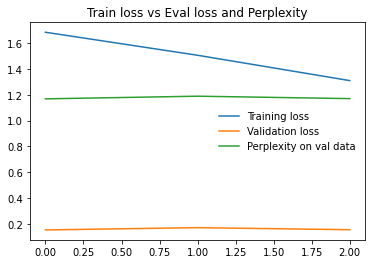

In [50]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [36]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in tqdm(enumerate(dataset_loader)):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=4,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results

In [37]:
def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [38]:
import math as m

n = 8

thresholds = []
for i in range(n):
    if i <= 2:
        if i!=2:
            thresholds.append(0.02 * i)
        else:
            nb11 = (0.02 * i) + m.exp(np.log(0.02 * i))/10
            nb22 = (0.02 * i) + m.exp(np.log(0.02 * i))/10 *i
            thresholds.append(0.02 * i)
            thresholds.append(nb11)
            thresholds.append(nb22)
            
        
    else:
        nb1 = (0.02 * i) + m.exp(np.log(0.02 * i))/10
        nb2 = (0.02 * i) + m.exp(np.log(0.02 * i))/10 *i
        thresholds.append(0.02 * i)
        thresholds.append(nb1)
        thresholds.append(nb2)

# [0.02 * i if i < 3 else (0.02 * i) + m.exp(np.log(0.02 * i))/10  for i in range(n)] #+ [0.1 * (i+1) for i in range(n)]

def get_scores_experiment(my_model, val_loader, config, thresholds: List):
        
    score_dict = {}
    result_dict = {}
    valid_tokens_info_dict = {}
    gates_out = {}
        
    for threshold in thresholds:
        
        config.threshold = threshold
        start_time = time.time()
        
        _results = generator(my_model, val_loader)
        score_ = get_score(_results)
        _, tokens_info, val_output = validation(my_model, val_loader, regularizer=config.reg,token_summaries=True )
        score_dict["scores_on_threshold_"+str(threshold)] = score_
        result_dict["results_wth_threshold_"+str(threshold)] = _results
        valid_tokens_info_dict["tonkens_wth_threshold_"+str(threshold)] = tokens_info
        gates_out["gates_on_threshold_"+str(threshold)] = val_output

        end_time = time.time()
        thr_mins, thr_secs = generate_time(start_time, end_time)
        
        print(f'Threshold: {threshold} | Threshold Time: {thr_mins}m {thr_secs}s')

    print("End Experiments !!!")

    return score_dict, result_dict, valid_tokens_info_dict, gates_out
        

#### Loading Saved Model

In [39]:
load_weights = True

if load_weights: 
    
    model = model.to(device) # first initialize the model and optimizer
    params = {'params': model.parameters()}
    optimizer = optim.Adam([params], lr=LEARNING_RATE) # optimizer then,
    #if wandb.run:
        # print('>>>>>> Here we Go !')
        # PATH = os.path.join('/content/wandb/run-20201222_084619-1esdptgn/files', 'final_model_reg0.4.003.pth')
    #else:
    PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks', 'independent_final_model_reg0.1.pth')
    
    load_pretrained_weights(model, optimizer, PATH, pretrained=load_weights)

##### Defining threshold ranges

In [40]:
thresholds = [-1.0, 0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25, 0.3,0.35, 0.4, 0.6,0.8]
len(thresholds)

14

In [ ]:
# thresholds = [0.01*i for i in range(16)]
# thresholds[0]=-1.0
# thresholds

In [42]:
set_seed()

argsval = {'max_article_tokens': 700,
                'max_summary_tokens': 250
             }

ivind = valind[5000:6000]
X_trial = X_valid.iloc[ivind]
Xval_trial = X_trial.reset_index(drop=True)    
val_loader  = get_dataloader(Xval_trial, 8,valid='valid', **argsval)

# itind = tind[5000:6000]
# X_try = X_test.iloc[itind]
# Xtest_try = X_try.reset_index(drop=True)
# test_loader  = get_dataloader(Xtest_try, 8,valid='valid', **argsval)

#### For validation data

In [ ]:
t5config.threshold = thresholds[4]
ww, tokens_info, val_output = validation(model, val_loader, regularizer=t5config.reg,token_summaries=True )

In [43]:
#%time results = generator(my_model, val_loader)
# model = model.to(device) 
score_dict, result_dict, valid_tokens_info_dict, gates_val_output = get_scores_experiment(model, val_loader, t5config, thresholds)

125it [16:12,  7.78s/it]
100%|██████████| 125/125 [00:33<00:00,  3.77it/s, loss=1.43]

Threshold: -1.0 | Threshold Time: 16m 47s



125it [09:34,  4.60s/it]
100%|██████████| 125/125 [00:33<00:00,  3.75it/s, loss=2.7]

Threshold: 0.02 | Threshold Time: 10m 9s



125it [14:45,  7.08s/it]
100%|██████████| 125/125 [00:33<00:00,  3.75it/s, loss=3.31]

Threshold: 0.04 | Threshold Time: 15m 20s



125it [22:27, 10.78s/it]
100%|██████████| 125/125 [00:33<00:00,  3.74it/s, loss=3.68]

Threshold: 0.06 | Threshold Time: 23m 3s



125it [21:47, 10.46s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=3.87]

Threshold: 0.08 | Threshold Time: 22m 23s



125it [17:47,  8.54s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=3.94]

Threshold: 0.1 | Threshold Time: 18m 22s



125it [08:01,  3.86s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=4]

Threshold: 0.15 | Threshold Time: 8m 37s



125it [05:43,  2.75s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=4.01]

Threshold: 0.2 | Threshold Time: 6m 19s



125it [05:45,  2.76s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=4.01]

Threshold: 0.25 | Threshold Time: 6m 20s



125it [05:42,  2.74s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=4.01]

Threshold: 0.3 | Threshold Time: 6m 17s



125it [05:41,  2.73s/it]
100%|██████████| 125/125 [00:33<00:00,  3.73it/s, loss=4.02]

Threshold: 0.35 | Threshold Time: 6m 16s



125it [05:44,  2.76s/it]
100%|██████████| 125/125 [00:33<00:00,  3.72it/s, loss=4.02]

Threshold: 0.4 | Threshold Time: 6m 19s



125it [30:07, 14.46s/it]
100%|██████████| 125/125 [00:33<00:00,  3.75it/s, loss=nan]

Threshold: 0.6 | Threshold Time: 30m 42s



125it [29:54, 14.36s/it]
100%|██████████| 125/125 [00:33<00:00,  3.75it/s, loss=nan]

Threshold: 0.8 | Threshold Time: 30m 28s
End Experiments !!!


In [46]:
score_dict

{'scores_on_threshold_-1.0': {'rouge1': 0.4059022611979226,
  'rouge2': 0.28298294437498717,
  'rougeL': 0.36264959154070353},
 'scores_on_threshold_0.02': {'rouge1': 0.333924320305544,
  'rouge2': 0.17281161127774447,
  'rougeL': 0.28595967077670975},
 'scores_on_threshold_0.04': {'rouge1': 0.23988047996334877,
  'rouge2': 0.07822309089828564,
  'rougeL': 0.1912226755817702},
 'scores_on_threshold_0.06': {'rouge1': 0.1594741018290923,
  'rouge2': 0.02903383785268178,
  'rougeL': 0.12311544872201911},
 'scores_on_threshold_0.08': {'rouge1': 0.1325868389904888,
  'rouge2': 0.015824578362028226,
  'rougeL': 0.10072865345808474},
 'scores_on_threshold_0.1': {'rouge1': 0.13369432717610813,
  'rouge2': 0.01168689359894218,
  'rougeL': 0.09958507429146612},
 'scores_on_threshold_0.15': {'rouge1': 0.1463364417024015,
  'rouge2': 0.007811324434025229,
  'rougeL': 0.10598114258027774},
 'scores_on_threshold_0.2': {'rouge1': 0.14752036248869813,
  'rouge2': 0.007184757845135144,
  'rougeL': 0.10

In [47]:
valid_tokens_info_dict

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(571475., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.02': (tensor(495882., device='cuda:0'),
  tensor(75593., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.04': (tensor(540687., device='cuda:0'),
  tensor(30788., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.06': (tensor(553131., device='cuda:0'),
  tensor(18344., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.08': (tensor(556639., device='cuda:0'),
  tensor(14836., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.1': (tensor(557736., device='cuda:0'),
  tensor(13739., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.15': (tensor(558390., device='cuda:0'),
  tensor(13085., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.2': (tensor(5

num_beam = 4, 1k \\
{'scores_on_threshold_0.1': {'rouge1': 0.4104657686592246,
  'rouge2': 0.29058499071845934,
  'rougeL': 0.3690283509649402}}

  ``````````````````````````````````````````

 {'tonkens_wth_threshold_0.1': (tensor(331903., device='cuda:0'),
  tensor(238404., device='cuda:0'),
  tensor(570307., device='cuda:0'))}

In [ ]:
score_dict

In [ ]:
valid_tokens_info_dict

# **START HERE!!!**



---



---



---





## **When model trained with regularizer ($\lambda$ = 0.4)**



In [48]:
# thresholds[0] = 0.0

rouge1 = []
rouge2 = []
rougeL = []
dropped = []
nonzerostokens = []
totaltokens = []
retained_rate = []
dropped_rates = []
gates_sum = []

for thr, thr_t in zip(score_dict.keys(), valid_tokens_info_dict.keys()):
    
    rouge1.append(score_dict[thr]['rouge1'])
    rouge2.append(score_dict[thr]['rouge2'])
    rougeL.append(score_dict[thr]['rougeL'])
    
    dropped.append(valid_tokens_info_dict[thr_t][0])
    nonzerostokens.append(valid_tokens_info_dict[thr_t][1])
    totaltokens.append(valid_tokens_info_dict[thr_t][-1])
    drop_rate = valid_tokens_info_dict[thr_t][1].item()/valid_tokens_info_dict[thr_t][-1].item()
    dropped_rates.append(1-drop_rate)
    retained_rate.append(drop_rate)
# for thr in gates_val_output.keys():
#   gates_sum.append(gates_val_output[thr])


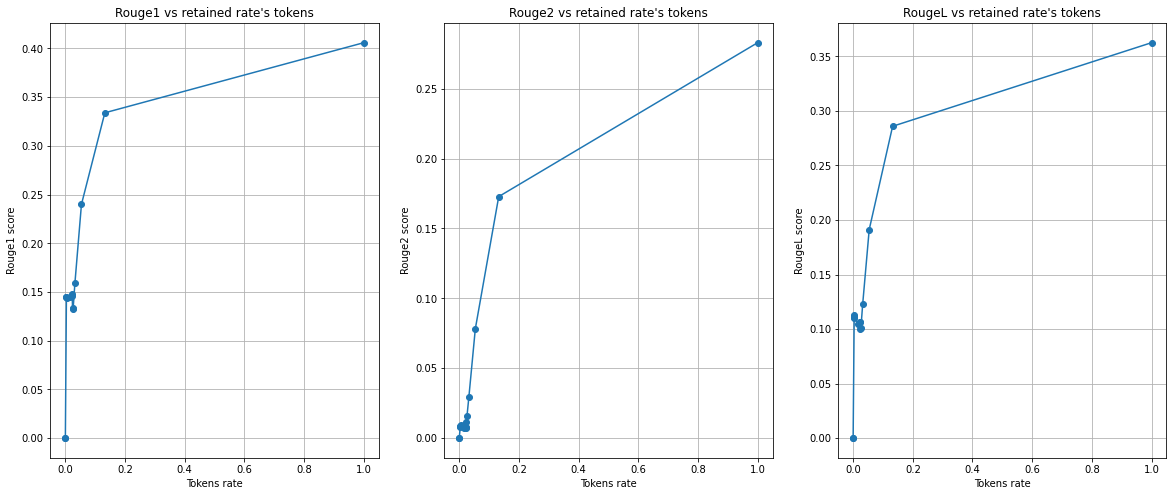

In [49]:
import matplotlib.pyplot as plt
import numpy as np

rouge11 = np.array(rouge1)
rouge22 = np.array(rouge2)
rougeLL = np.array(rougeL)

rate = np.array(retained_rate)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(rate,rouge11, 'o-')
axes[0].set_xlabel('Tokens rate')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs retained rate's tokens")
axes[0].grid()

axes[1].plot(rate,rouge22, 'o-')
#axes[1].axis('tight')
axes[1].set_xlabel('Tokens rate')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs retained rate's tokens")
axes[1].grid()

axes[2].plot(rate,rougeLL, 'o-')
axes[2].set_xlabel('Tokens rate')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs retained rate's tokens");
axes[2].grid()

In [50]:
rate

array([1.        , 0.132277  , 0.05387462, 0.03209939, 0.02596089,
       0.0240413 , 0.02289689, 0.02250842, 0.01575747, 0.0042889 ,
       0.0037027 , 0.00349272, 0.        , 0.        ])

In [51]:
rouge1

[0.4059022611979226,
 0.333924320305544,
 0.23988047996334877,
 0.1594741018290923,
 0.1325868389904888,
 0.13369432717610813,
 0.1463364417024015,
 0.14752036248869813,
 0.1443122158941228,
 0.14401078932909472,
 0.14461791552759773,
 0.14464991128177795,
 0.0,
 0.0]

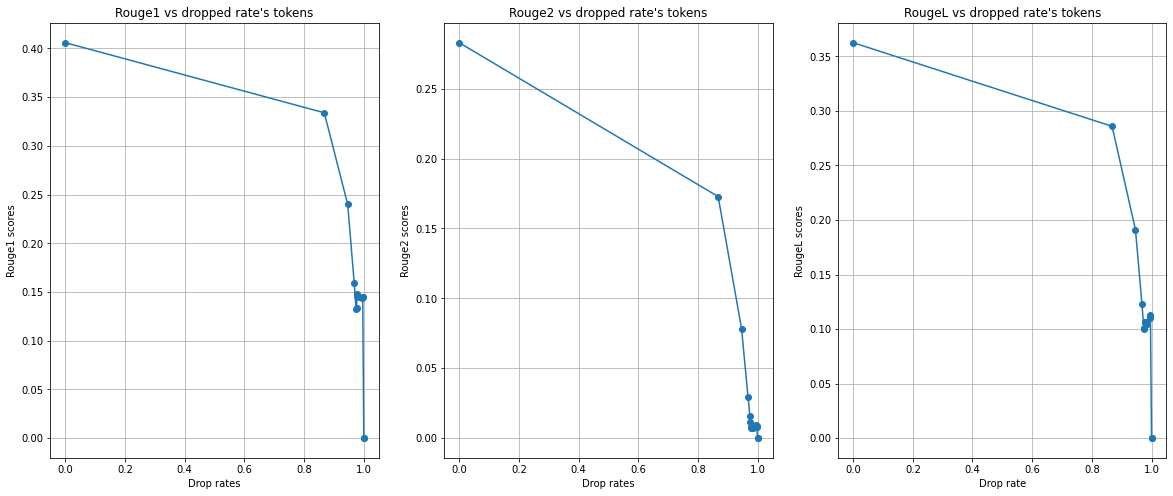

In [52]:
import matplotlib.pyplot as plt

rouge11 = np.array(rouge1)
rouge22 = np.array(rouge2)
rougeLL = np.array(rougeL)

rate1 = np.array(dropped_rates)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(rate1,rouge11, 'o-')
axes[0].set_xlabel('Drop rates')
axes[0].set_ylabel('Rouge1 scores')
axes[0].set_title("Rouge1 vs dropped rate's tokens")
axes[0].grid(True)

axes[1].plot(rate1,rouge22, 'o-')
#axes[1].axis('tight')
axes[1].set_xlabel('Drop rates')
axes[1].set_ylabel('Rouge2 scores')
axes[1].set_title("Rouge2 vs dropped rate's tokens")
axes[1].grid(True)

axes[2].plot(rate1,rougeLL, 'o-')
axes[2].set_xlabel('Drop rate')
axes[2].set_ylabel('RougeL scores')
axes[2].set_title("RougeL vs dropped rate's tokens");
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/valid_same_gates_new_thresholds_alldroprate0.1.png')

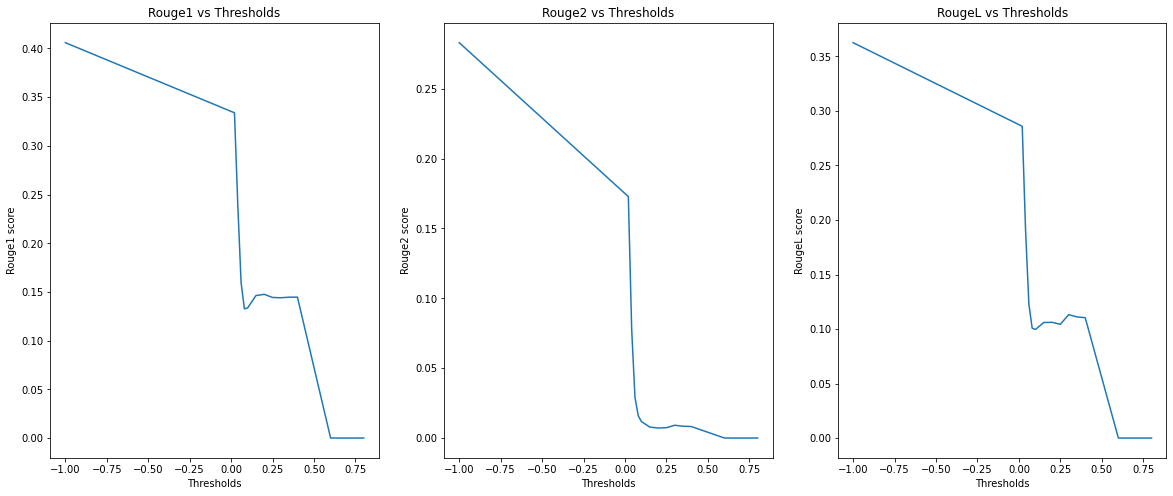

In [53]:
figure, axeses = plt.subplots(1, 3, figsize=(20, 8))
#thresholds = thrsholdss
#thresholds[0] = 0.0

axeses[0].plot(thresholds,rouge11)
axeses[0].set_xlabel('Thresholds')
axeses[0].set_ylabel('Rouge1 score')
axeses[0].set_title("Rouge1 vs Thresholds")

axeses[1].plot(thresholds,rouge22)
#axes[1].axis('tight')
axeses[1].set_xlabel('Thresholds')
axeses[1].set_ylabel('Rouge2 score')
axeses[1].set_title("Rouge2 vs Thresholds")

axeses[2].plot(thresholds,rougeLL)
axeses[2].set_xlabel('Thresholds')
axeses[2].set_ylabel('RougeL score')
axeses[2].set_title("RougeL vs Thresholds");

In [54]:
import glob
import pandas as pd
path = glob.glob('/content/drive/MyDrive/Colab Notebooks/Results_csv/*resultsgcp.csv')
#t5model = {'reg': 0.2, 'threshold': 0.003}
path

[]

In [55]:
def get_metric(rouge1,rouge2,rougeL, dropped_rates, retained_rate, valid_tokens_info_dict, thresholds, t5config, thr_train, name_data='valid', path = None):
  
  l = len(rouge1)
  totaltokens = [valid_tokens_info_dict['tonkens_wth_threshold_-1.0'][-1].item()]*l
  reg = [t5config.reg]*l
  threshold_train = [thr_train]*l
  data = {'Thresholds':thresholds,'Reg':reg,'Threshold_train':threshold_train,'Rouge1':rouge1,'Rouge2':rouge2,'RougeL':rougeL, 'dropped_rates':dropped_rates, 'retained_rate':retained_rate, 'total_tokens':totaltokens}
  df = pd.DataFrame(data)
  
  if path is not None:
    load_dataframe = pd.read_csv(path[-1])
    df_ = pd.concat([df, load_dataframe], ignore_index=True)
    date = pd.datetime.now().strftime(format='%Y-%m-%d_%H%M_')
    df_.to_csv(f'/content/drive/MyDrive/Colab Notebooks/{t5config.reg}_{thr_train}{name_data}_results.csv')
  else:
    date = pd.datetime.now().strftime(format='%Y-%m-%d_%H%M_')
    df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Results_csv/{date}{t5config.reg}_{thr_train}{name_data}_results.csv')

In [56]:
get_metric(rouge1,rouge2,rougeL, dropped_rates, retained_rate, valid_tokens_info_dict, thresholds,t5config, 0.003,name_data='older_model.1_new_thresholds_nbeam4', path=None)

## **When model trained with regularizer ($\lambda$ = 0.7)**


In [ ]:
t5config.reg = 0.4

In [ ]:
# For test data val_output
# score_dictt, result_dictt, valid_tokens_info_dictt, val_output = get_scores_experiment(model, test_loader, config, thresholds)
score_dictt, result_dictt, valid_tokens_info_dictt, gates_val_outputt = get_scores_experiment(model, val_loader, t5config, thresholds[:6])

250it [1:00:36, 14.55s/it]
100%|██████████| 250/250 [01:05<00:00,  3.84it/s, loss=1.59]

Threshold: -1.0 | Threshold Time: 61m 45s



250it [58:41, 14.09s/it]
100%|██████████| 250/250 [01:04<00:00,  3.89it/s, loss=1.59]

Threshold: 0.02 | Threshold Time: 59m 50s



250it [56:46, 13.63s/it]
100%|██████████| 250/250 [01:04<00:00,  3.87it/s, loss=1.59]

Threshold: 0.04 | Threshold Time: 57m 55s



250it [55:43, 13.38s/it]
100%|██████████| 250/250 [01:04<00:00,  3.88it/s, loss=1.6]

Threshold: 0.06 | Threshold Time: 56m 52s



250it [50:33, 12.13s/it]
100%|██████████| 250/250 [01:04<00:00,  3.88it/s, loss=1.61]

Threshold: 0.08 | Threshold Time: 51m 41s



250it [46:51, 11.24s/it]
100%|██████████| 250/250 [01:04<00:00,  3.88it/s, loss=1.64]

Threshold: 0.1 | Threshold Time: 47m 59s
End Experiments !!!


In [ ]:
score_dictt

{'scores_on_threshold_-1.0': {'rouge1': 0.3969097755421286,
  'rouge2': 0.27583600469780944,
  'rougeL': 0.35281577537475506},
 'scores_on_threshold_0.02': {'rouge1': 0.39675449470664687,
  'rouge2': 0.27626916440809857,
  'rougeL': 0.353179025128729},
 'scores_on_threshold_0.04': {'rouge1': 0.3956761223225719,
  'rouge2': 0.2750325302881088,
  'rougeL': 0.3515278111894019},
 'scores_on_threshold_0.06': {'rouge1': 0.3963516436112228,
  'rouge2': 0.27453655680055955,
  'rougeL': 0.3523554908475556},
 'scores_on_threshold_0.08': {'rouge1': 0.3977419293312259,
  'rouge2': 0.2759165913282515,
  'rougeL': 0.3531040669995972},
 'scores_on_threshold_0.1': {'rouge1': 0.4010840223764317,
  'rouge2': 0.27946711934805823,
  'rougeL': 0.3563890268756459}}

In [ ]:
valid_tokens_info_dictt

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(1140716., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.02': (tensor(329541., device='cuda:0'),
  tensor(811175., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.04': (tensor(377331., device='cuda:0'),
  tensor(763385., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.06': (tensor(458821., device='cuda:0'),
  tensor(681895., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.08': (tensor(558809., device='cuda:0'),
  tensor(581907., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.1': (tensor(661790., device='cuda:0'),
  tensor(478926., device='cuda:0'),
  tensor(1140716., device='cuda:0'))}

In [ ]:
rouge1t = []
rouge2t = []
rougeLt = []
droppedt = []
nonzerostokenst = []
totaltokenst = []
retained_ratet = []
dropped_ratest = []

for thrt, thr_tt in zip(score_dictt.keys(), valid_tokens_info_dictt.keys()):
    
    rouge1t.append(score_dictt[thrt]['rouge1'])
    rouge2t.append(score_dictt[thrt]['rouge2'])
    rougeLt.append(score_dictt[thrt]['rougeL'])
    
    droppedt.append(valid_tokens_info_dictt[thr_tt][0])
    nonzerostokenst.append(valid_tokens_info_dictt[thr_tt][1])
    totaltokenst.append(valid_tokens_info_dictt[thr_tt][-1])
    drop_ratet = valid_tokens_info_dictt[thr_tt][1].item()/valid_tokens_info_dictt[thr_tt][-1].item()
    dropped_ratest.append(1-drop_ratet)

    retained_ratet.append(drop_ratet)

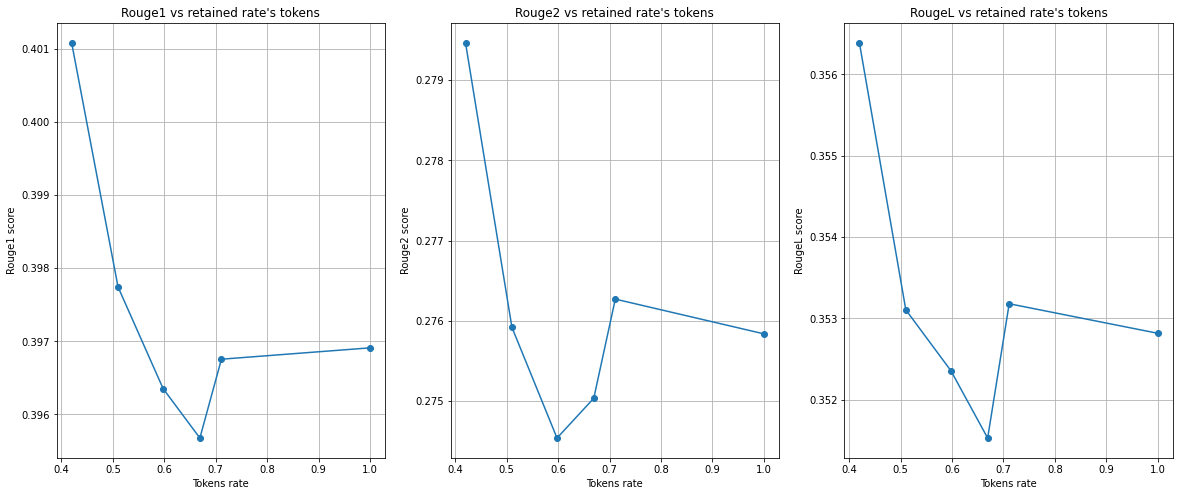

In [ ]:
import matplotlib.pyplot as plt

rouge11t = np.array(rouge1t)
rouge22t = np.array(rouge2t)
rougeLLt = np.array(rougeLt)

ratet = np.array(retained_ratet)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(ratet,rouge11t, 'o-')
axes[0].set_xlabel('Tokens rate')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs retained rate's tokens")
axes[0].grid(True)

axes[1].plot(ratet,rouge22t, 'o-')
#axes[1].axis('tight')
axes[1].set_xlabel('Tokens rate')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs retained rate's tokens")
axes[1].grid(True)

axes[2].plot(ratet,rougeLLt, 'o-')
axes[2].set_xlabel('Tokens rate')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs retained rate's tokens")
axes[2].grid(True)


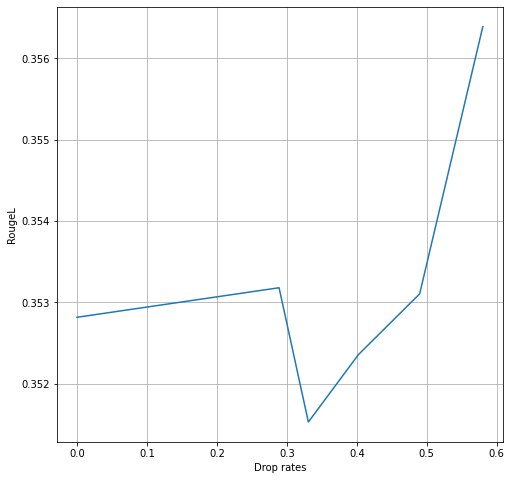

In [ ]:
plt.figure(figsize=(8, 8))
aa = np.array(dropped_ratest)
rr = np.array(rougeLt)
plt.plot(aa,rr)
plt.xlabel('Drop rates')
plt.ylabel('RougeL')
plt.grid()
#plt.savefig('/content/drive/MyDrive/images/rL0.2.png')

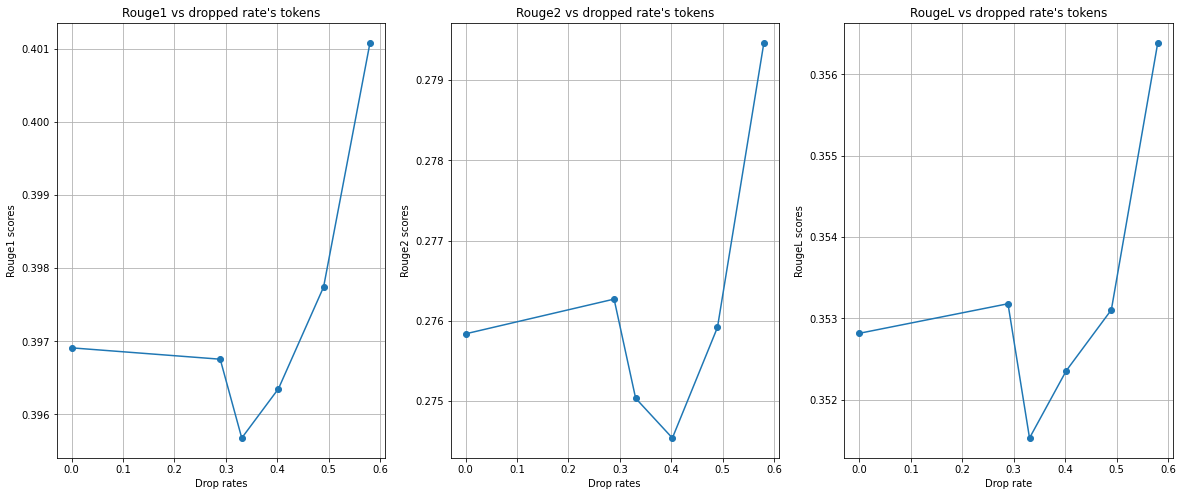

In [ ]:
import matplotlib.pyplot as plt

rate1 = np.array(dropped_ratest)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(rate1,rouge11t, 'o-')
axes[0].set_xlabel('Drop rates')
axes[0].set_ylabel('Rouge1 scores')
axes[0].set_title("Rouge1 vs dropped rate's tokens")
axes[0].grid(True)

axes[1].plot(rate1,rouge22t, 'o-')
#axes[1].axis('tight')
axes[1].set_xlabel('Drop rates')
axes[1].set_ylabel('Rouge2 scores')
axes[1].set_title("Rouge2 vs dropped rate's tokens")
axes[1].grid(True)

axes[2].plot(rate1,rougeLLt, 'o-')
axes[2].set_xlabel('Drop rate')
axes[2].set_ylabel('RougeL scores')
axes[2].set_title("RougeL vs dropped rate's tokens");
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/test_new_valid_alldroprate0.1.png')

In [ ]:
thresh = np.array(thresholds)
thresh[0] = 0
figg, axess = plt.subplots(1, 3, figsize=(20, 8))

axess[0].plot(thresh,rouge11t)
axess[0].set_xlabel('Thresholds')
axess[0].set_ylabel('Rouge1 score')
axess[0].set_title("Rouge1 vs Thresholds")

axess[1].plot(thresh,rouge22t)
#axes[1].axis('tight')
axess[1].set_xlabel('Thresholds')
axess[1].set_ylabel('Rouge2 score')
axess[1].set_title("Rouge2 vs Thresholds")

axess[2].plot(thresh,rougeLLt)
axess[2].set_xlabel('Thresholds')
axess[2].set_ylabel('RougeL score')
axess[2].set_title("RougeL vs Thresholds");

In [ ]:
rouge1t

[0.3969097755421286,
 0.39675449470664687,
 0.3956761223225719,
 0.3963516436112228,
 0.3977419293312259,
 0.4010840223764317]

In [ ]:
score_dictt

{'scores_on_threshold_-1.0': {'rouge1': 0.39224260405642425,
  'rouge2': 0.26000466155310875,
  'rougeL': 0.3443635441860196},
 'scores_on_threshold_0.02': {'rouge1': 0.39219447126763224,
  'rouge2': 0.26111480382773444,
  'rougeL': 0.3442525767968181},
 'scores_on_threshold_0.04': {'rouge1': 0.39234093097717304,
  'rouge2': 0.26115716433963454,
  'rougeL': 0.34467936232085084},
 'scores_on_threshold_0.06': {'rouge1': 0.39259848599165514,
  'rouge2': 0.2612753073956383,
  'rougeL': 0.34526887685642116},
 'scores_on_threshold_0.08': {'rouge1': 0.39571094420451103,
  'rouge2': 0.2639901529889146,
  'rougeL': 0.34788403077571095},
 'scores_on_threshold_0.1': {'rouge1': 0.3972609779753837,
  'rouge2': 0.26558943594400586,
  'rougeL': 0.34999944601897115},
 'scores_on_threshold_0.15': {'rouge1': 0.3794386995356336,
  'rouge2': 0.24514470640990488,
  'rougeL': 0.3338112788131523},
 'scores_on_threshold_0.2': {'rouge1': 0.33621644577302157,
  'rouge2': 0.19884996444296255,
  'rougeL': 0.29499

In [ ]:
valid_tokens_info_dictt

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(1140716., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.02': (tensor(329542., device='cuda:0'),
  tensor(811174., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.04': (tensor(377331., device='cuda:0'),
  tensor(763385., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.06': (tensor(458821., device='cuda:0'),
  tensor(681895., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.08': (tensor(558809., device='cuda:0'),
  tensor(581907., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.1': (tensor(661790., device='cuda:0'),
  tensor(478926., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0.15': (tensor(874751., device='cuda:0'),
  tensor(265965., device='cuda:0'),
  tensor(1140716., device='cuda:0')),
 'tonkens_wth_threshold_0

In [ ]:
get_metric(rouge1t,rouge2t,rougeLt, dropped_ratest, retained_ratet, valid_tokens_info_dictt, thresholds, t5config, 0.003,name_data='model0.1_test2k',path=None)

{'Thresholds': [-1.0, 0.02, 0.04, 0.06, 0.08, 0.1], 'Reg': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'Threshold_train': [0.003, 0.003, 0.003, 0.003, 0.003, 0.003], 'Rouge1': [0.3969097755421286, 0.39675449470664687, 0.3956761223225719, 0.3963516436112228, 0.3977419293312259, 0.4010840223764317], 'Rouge2': [0.27583600469780944, 0.27626916440809857, 0.2750325302881088, 0.27453655680055955, 0.2759165913282515, 0.27946711934805823], 'RougeL': [0.35281577537475506, 0.353179025128729, 0.3515278111894019, 0.3523554908475556, 0.3531040669995972, 0.3563890268756459], 'dropped_rates': [0.0, 0.28888960968374244, 0.33078434947874846, 0.4022219378004692, 0.4898756570434709, 0.5801531669582964], 'retained_rate': [1.0, 0.7111103903162576, 0.6692156505212515, 0.5977780621995308, 0.5101243429565291, 0.4198468330417036], 'total_tokens': [1140716.0, 1140716.0, 1140716.0, 1140716.0, 1140716.0, 1140716.0]}


## **When model trained with regularizer ($\lambda$ = 0.2)**


In [ ]:
t5config

In [ ]:
score_dictb, result_dictb, valid_tokens_info_dictb, gates_val_outputb = get_scores_experiment(model, val_loader, t5config, thresholds)

125it [09:42,  4.66s/it]
100%|██████████| 125/125 [00:32<00:00,  3.84it/s, loss=1.67]

Threshold: -1.0 | Threshold Time: 10m 17s



125it [09:48,  4.71s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=1.67]

Threshold: 0.02 | Threshold Time: 10m 23s



125it [09:22,  4.50s/it]
100%|██████████| 125/125 [00:32<00:00,  3.84it/s, loss=1.68]

Threshold: 0.04 | Threshold Time: 9m 57s



125it [09:11,  4.41s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=1.7]

Threshold: 0.06 | Threshold Time: 9m 45s



125it [08:19,  3.99s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=1.77]

Threshold: 0.08 | Threshold Time: 8m 53s



125it [07:12,  3.46s/it]
100%|██████████| 125/125 [00:32<00:00,  3.86it/s, loss=1.89]

Threshold: 0.1 | Threshold Time: 7m 46s



125it [05:50,  2.80s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=2.39]

Threshold: 0.15 | Threshold Time: 6m 24s



125it [05:45,  2.77s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=3.05]

Threshold: 0.2 | Threshold Time: 6m 19s



125it [05:43,  2.74s/it]
100%|██████████| 125/125 [00:32<00:00,  3.86it/s, loss=3.59]

Threshold: 0.25 | Threshold Time: 6m 16s



125it [05:41,  2.73s/it]
100%|██████████| 125/125 [00:32<00:00,  3.87it/s, loss=3.92]

Threshold: 0.3 | Threshold Time: 6m 15s



125it [05:08,  2.47s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=4.06]

Threshold: 0.35 | Threshold Time: 5m 42s



125it [04:41,  2.25s/it]
100%|██████████| 125/125 [00:32<00:00,  3.85it/s, loss=4.12]

Threshold: 0.4 | Threshold Time: 5m 15s



125it [03:53,  1.87s/it]
100%|██████████| 125/125 [00:32<00:00,  3.84it/s, loss=4.15]

Threshold: 0.6 | Threshold Time: 4m 27s



125it [03:55,  1.88s/it]
100%|██████████| 125/125 [00:32<00:00,  3.84it/s, loss=4.15]

Threshold: 0.8 | Threshold Time: 4m 29s
End Experiments !!!


In [ ]:
score_dictb

{'scores_on_threshold_-1.0': {'rouge1': 0.3680686579054278,
  'rouge2': 0.234592526208463,
  'rougeL': 0.32119777287439394},
 'scores_on_threshold_0.02': {'rouge1': 0.3699198883731987,
  'rouge2': 0.2359631187007524,
  'rougeL': 0.3229234478076428},
 'scores_on_threshold_0.04': {'rouge1': 0.36987286184183077,
  'rouge2': 0.23772649008427776,
  'rougeL': 0.32439940396284134},
 'scores_on_threshold_0.06': {'rouge1': 0.3718422619241314,
  'rouge2': 0.23685992186180796,
  'rougeL': 0.3243383783287946},
 'scores_on_threshold_0.08': {'rouge1': 0.37278618019156806,
  'rouge2': 0.23921547783057734,
  'rougeL': 0.3266407816380043},
 'scores_on_threshold_0.1': {'rouge1': 0.364966018683188,
  'rouge2': 0.2334657977784129,
  'rougeL': 0.3214224572111062},
 'scores_on_threshold_0.15': {'rouge1': 0.3050984697063243,
  'rouge2': 0.17006052573746058,
  'rougeL': 0.2637824482536233},
 'scores_on_threshold_0.2': {'rouge1': 0.23300255106374496,
  'rouge2': 0.09659965708974082,
  'rougeL': 0.1977265878720

In [ ]:
valid_tokens_info_dictb

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(571475., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.02': (tensor(171179., device='cuda:0'),
  tensor(400296., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.04': (tensor(211752., device='cuda:0'),
  tensor(359723., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.06': (tensor(282693., device='cuda:0'),
  tensor(288782., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.08': (tensor(353431., device='cuda:0'),
  tensor(218044., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.1': (tensor(412792., device='cuda:0'),
  tensor(158683., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.15': (tensor(506388., device='cuda:0'),
  tensor(65087., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.2': (ten

In [ ]:
rouge1tb = []
rouge2tb = []
rougeLtb = []
droppedtb = []
nonzerostokenstb = []
totaltokenstb = []
retained_ratetb = []
dropped_ratestb = []

for thrt, thr_tt in zip(score_dictb.keys(), valid_tokens_info_dictb.keys()):
    
    rouge1tb.append(score_dictb[thrt]['rouge1'])
    rouge2tb.append(score_dictb[thrt]['rouge2'])
    rougeLtb.append(score_dictb[thrt]['rougeL'])
    
    droppedtb.append(valid_tokens_info_dictb[thr_tt][0])
    nonzerostokenstb.append(valid_tokens_info_dictb[thr_tt][1])
    totaltokenstb.append(valid_tokens_info_dictb[thr_tt][-1])
    drop_ratetb = valid_tokens_info_dictb[thr_tt][1].item()/valid_tokens_info_dictb[thr_tt][-1].item()
    dropped_ratestb.append(1-drop_ratetb)

    retained_ratetb.append(drop_ratetb)

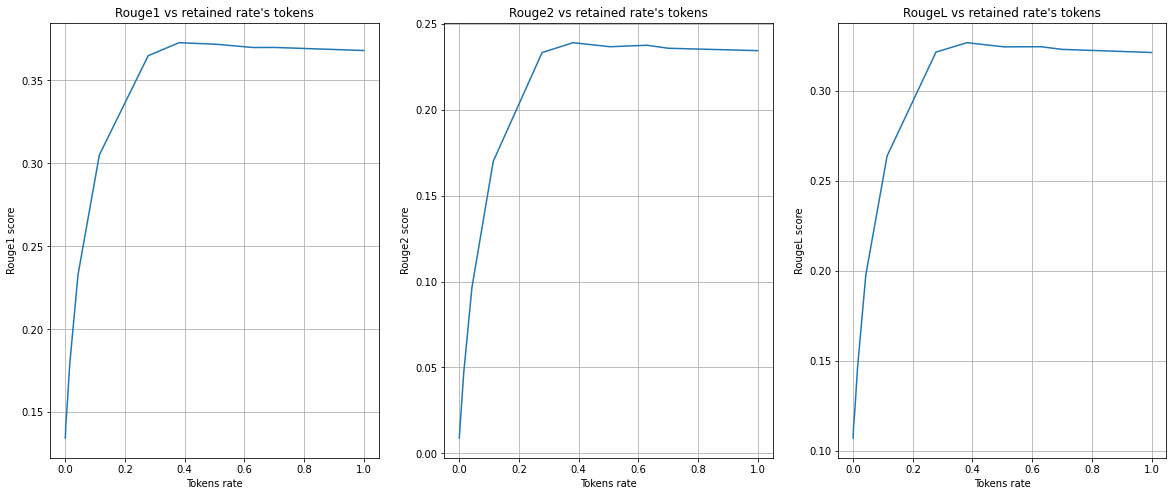

In [ ]:
import matplotlib.pyplot as plt

rouge1b = np.array(rouge1tb)
rouge2b = np.array(rouge2tb)
rougeLb = np.array(rougeLtb)

ratet = np.array(retained_ratetb)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(ratet,rouge1b)
axes[0].set_xlabel('Tokens rate')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs retained rate's tokens")
axes[0].grid(True)

axes[1].plot(ratet,rouge2b)
#axes[1].axis('tight')
axes[1].set_xlabel('Tokens rate')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs retained rate's tokens")
axes[1].grid(True)

axes[2].plot(ratet,rougeLb)
axes[2].set_xlabel('Tokens rate')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs retained rate's tokens")
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/new-same_gate_alldrop_rate0.6.png')

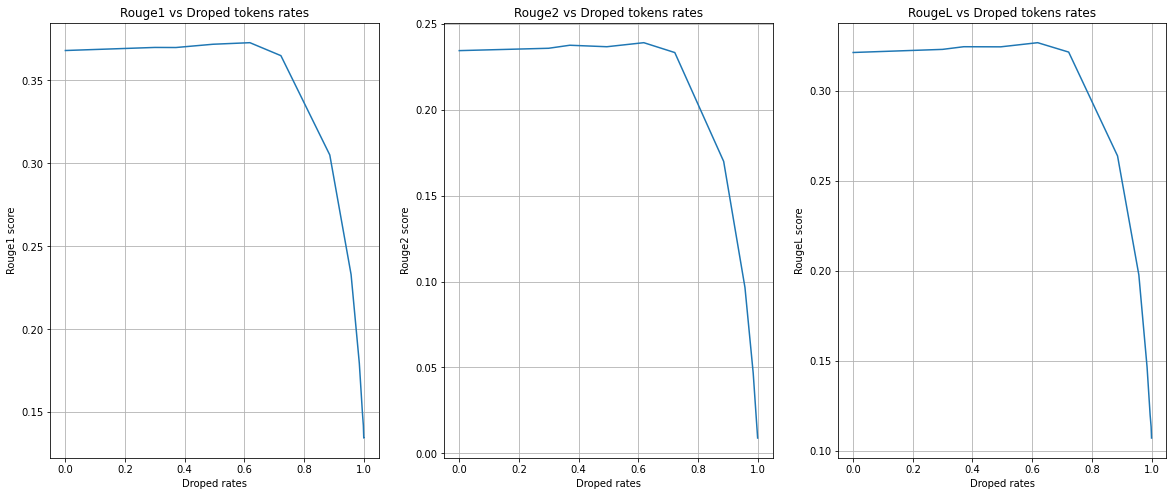

In [ ]:
import matplotlib.pyplot as plt

rouge1b = np.array(rouge1tb)
rouge2b = np.array(rouge2tb)
rougeLb = np.array(rougeLtb)

dropped_rates = np.array(dropped_ratestb)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(dropped_rates,rouge1b)
axes[0].set_xlabel('Droped rates')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs Droped tokens rates")
axes[0].grid(True)

axes[1].plot(dropped_rates,rouge2b)
#axes[1].axis('tight')
axes[1].set_xlabel('Droped rates')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs Droped tokens rates")
axes[1].grid(True)

axes[2].plot(dropped_rates,rougeLb)
axes[2].set_xlabel('Droped rates')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs Droped tokens rates")
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/same_gates_new_thresholds_alldroprate0.2.png')


In [ ]:
get_metric(rouge1tb, rouge2tb, rougeLtb, dropped_ratestb, retained_ratetb, valid_tokens_info_dictb, thresholds, t5config, 0.003,'model0.2_valid', path=None)

In [ ]:
score_dicts, result_dicts, valid_tokens_info_dicts, gates_val_outputs = get_scores_experiment(model, val_loader, t5config, thresholds)

125it [14:39,  7.04s/it]
100%|██████████| 125/125 [00:50<00:00,  2.46it/s, loss=1.68]

Threshold: -1.0 | Threshold Time: 15m 32s



125it [13:52,  6.66s/it]
100%|██████████| 125/125 [00:50<00:00,  2.46it/s, loss=1.68]

Threshold: 0.02 | Threshold Time: 14m 45s



125it [13:27,  6.46s/it]
100%|██████████| 125/125 [00:51<00:00,  2.45it/s, loss=1.69]

Threshold: 0.04 | Threshold Time: 14m 20s



125it [12:53,  6.19s/it]
100%|██████████| 125/125 [00:51<00:00,  2.45it/s, loss=1.71]

Threshold: 0.06 | Threshold Time: 13m 46s



125it [11:46,  5.65s/it]
100%|██████████| 125/125 [00:50<00:00,  2.45it/s, loss=1.78]

Threshold: 0.08 | Threshold Time: 12m 39s



125it [11:15,  5.41s/it]
100%|██████████| 125/125 [00:51<00:00,  2.45it/s, loss=1.89]

Threshold: 0.1 | Threshold Time: 12m 8s



125it [08:48,  4.23s/it]
100%|██████████| 125/125 [00:50<00:00,  2.46it/s, loss=2.41]

Threshold: 0.15 | Threshold Time: 9m 41s



125it [07:47,  3.74s/it]
100%|██████████| 125/125 [00:50<00:00,  2.45it/s, loss=3.04]

Threshold: 0.2 | Threshold Time: 8m 40s



125it [08:39,  4.16s/it]
100%|██████████| 125/125 [00:51<00:00,  2.44it/s, loss=3.5]

Threshold: 0.25 | Threshold Time: 9m 32s



125it [08:17,  3.98s/it]
100%|██████████| 125/125 [00:51<00:00,  2.44it/s, loss=3.79]

Threshold: 0.3 | Threshold Time: 9m 10s



125it [07:47,  3.74s/it]
100%|██████████| 125/125 [00:51<00:00,  2.44it/s, loss=3.96]

Threshold: 0.35 | Threshold Time: 8m 40s



125it [08:25,  4.05s/it]
100%|██████████| 125/125 [00:51<00:00,  2.44it/s, loss=4.05]

Threshold: 0.4 | Threshold Time: 9m 18s



125it [07:39,  3.67s/it]
100%|██████████| 125/125 [00:51<00:00,  2.44it/s, loss=4.11]

Threshold: 0.6 | Threshold Time: 8m 32s



125it [07:38,  3.67s/it]
100%|██████████| 125/125 [00:51<00:00,  2.43it/s, loss=4.12]

Threshold: 0.8 | Threshold Time: 8m 31s
End Experiments !!!


In [ ]:
score_dicts

{'scores_on_threshold_-1.0': {'rouge1': 0.3674441866950058,
  'rouge2': 0.23605163553284644,
  'rougeL': 0.32153297074415865},
 'scores_on_threshold_0.02': {'rouge1': 0.3701325218389315,
  'rouge2': 0.23868233608498113,
  'rougeL': 0.32382090049915857},
 'scores_on_threshold_0.04': {'rouge1': 0.37003588914795005,
  'rouge2': 0.23851015780007095,
  'rougeL': 0.32297075280570164},
 'scores_on_threshold_0.06': {'rouge1': 0.3679866783575193,
  'rouge2': 0.23366434094749688,
  'rougeL': 0.3210890369555488},
 'scores_on_threshold_0.08': {'rouge1': 0.3654640213506445,
  'rouge2': 0.23272708582489376,
  'rougeL': 0.3198650760756553},
 'scores_on_threshold_0.1': {'rouge1': 0.3533692737525347,
  'rouge2': 0.2187197028233552,
  'rougeL': 0.30816598776352827},
 'scores_on_threshold_0.15': {'rouge1': 0.3149499282206722,
  'rouge2': 0.17946644879825316,
  'rougeL': 0.2714949579550366},
 'scores_on_threshold_0.2': {'rouge1': 0.25342690702363446,
  'rouge2': 0.1191595000136983,
  'rougeL': 0.216807123

In [ ]:
valid_tokens_info_dicts

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(571475., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.02': (tensor(225783., device='cuda:0'),
  tensor(345692., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.04': (tensor(261880., device='cuda:0'),
  tensor(309595., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.06': (tensor(320183., device='cuda:0'),
  tensor(251292., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.08': (tensor(382139., device='cuda:0'),
  tensor(189336., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.1': (tensor(433921., device='cuda:0'),
  tensor(137554., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.15': (tensor(514101., device='cuda:0'),
  tensor(57374., device='cuda:0'),
  tensor(571475., device='cuda:0')),
 'tonkens_wth_threshold_0.2': (ten

In [ ]:
rouge1s = []
rouge2s = []
rougeLs = []
droppeds = []
nonzerostokenss = []
totaltokenss = []
retained_ratess = []
dropped_ratess= []

for thrt, thr_tt in zip(score_dicts.keys(), valid_tokens_info_dicts.keys()):
    
    rouge1s.append(score_dicts[thrt]['rouge1'])
    rouge2s.append(score_dicts[thrt]['rouge2'])
    rougeLs.append(score_dicts[thrt]['rougeL'])
    
    droppeds.append(valid_tokens_info_dicts[thr_tt][0])
    nonzerostokenss.append(valid_tokens_info_dicts[thr_tt][1])
    totaltokenss.append(valid_tokens_info_dicts[thr_tt][-1])
    drop_ratets = valid_tokens_info_dicts[thr_tt][1].item()/valid_tokens_info_dicts[thr_tt][-1].item()
    dropped_ratess.append(1-drop_ratets)

    retained_ratess.append(drop_ratets)

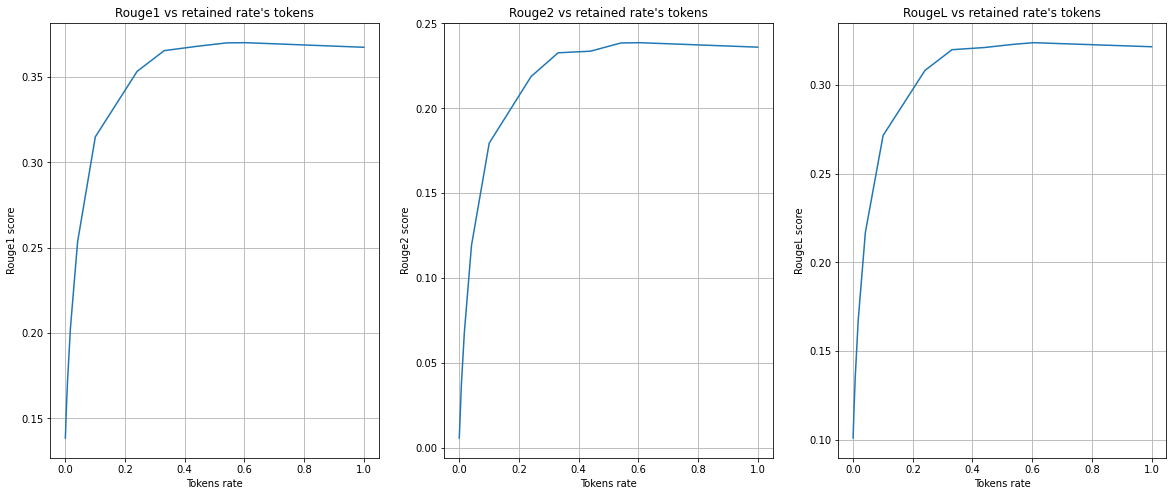

In [ ]:
import matplotlib.pyplot as plt

ratets = np.array(retained_ratess)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(ratets,rouge1s)
axes[0].set_xlabel('Tokens rate')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs retained rate's tokens")
axes[0].grid(True)

axes[1].plot(ratets,rouge2s)
#axes[1].axis('tight')
axes[1].set_xlabel('Tokens rate')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs retained rate's tokens")
axes[1].grid(True)

axes[2].plot(ratets,rougeLs)
axes[2].set_xlabel('Tokens rate')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs retained rate's tokens")
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/new-same_gate_all_retained_rate0.6.png')

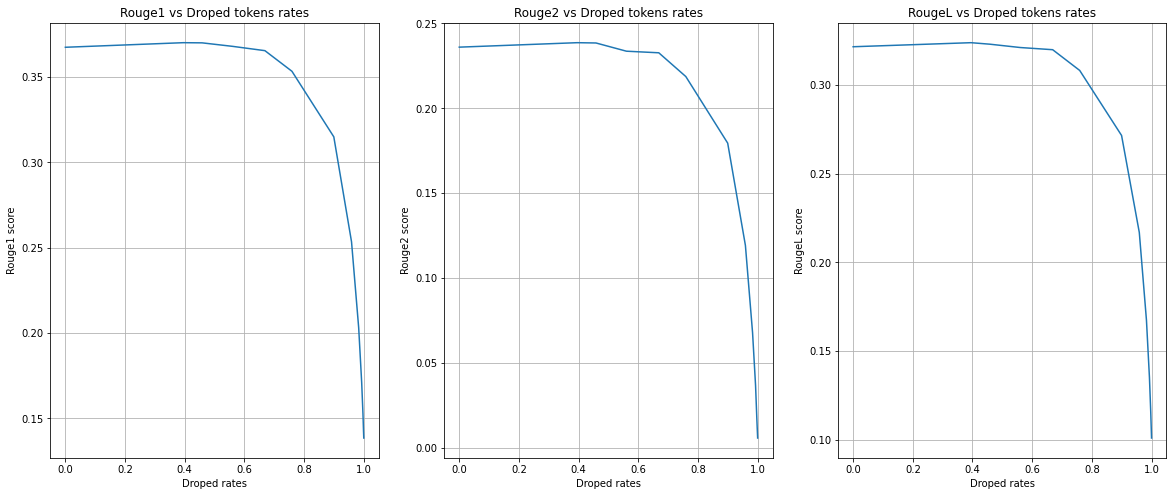

In [ ]:
dropped_ratess = np.array(dropped_ratess)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(dropped_ratess,rouge1s)
axes[0].set_xlabel('Droped rates')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs Droped tokens rates")
axes[0].grid(True)

axes[1].plot(dropped_ratess,rouge2s)
#axes[1].axis('tight')
axes[1].set_xlabel('Droped rates')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs Droped tokens rates")
axes[1].grid(True)

axes[2].plot(dropped_ratess,rougeLs)
axes[2].set_xlabel('Droped rates')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs Droped tokens rates")
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/same_gates_new_thresholds_alldroprate0.6.png')


In [ ]:
get_metric(rouge1s, rouge2s, rougeLs, dropped_ratess, retained_ratess, valid_tokens_info_dicts, thresholds, t5config, 0.003,name_data='model_reg0.6_new_thresholds', path=None)

#### __Ploting Gates and Scores__

In [ ]:
ivind = valind[5000:5008]
X_trial = X_valid.iloc[ivind]
Xval_trial = X_trial.reset_index(drop=True)    
valloader  = get_dataloader(Xval_trial, 8,valid='valid', **argsval)

Ploting scores

In [ ]:
path

['/content/drive/MyDrive/Colab Notebooks/Results_csv/0.2_0.003valid_resultsgcp.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/0.6_0.003valid_resultsgcp.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/0.4_0.003valid_resultsgcp.csv']

In [ ]:
import glob

pathcolab = glob.glob('/content/drive/MyDrive/Colab Notebooks/Results_csv/*new_thresholds*.csv')
pathcolab

['/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-15_0842_0.2_0.003model_reg00_new_thresholds_resultscolab.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-15_1042_0.4_0.003valid_new_thresholds_resultscolab.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-15_1251_0.6_0.003model_reg06_new_thresholds_resultscolab.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-17_0808_0.0_0.003model_reg00_new_thresholds_results.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-17_1014_0.4_0.003model0.4_valid_new_thresholds_results.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-18_0913_0.0_0.003model_reg0.6_new_thresholds_results.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-22_0737_0.1_0.003model_reg01_new_thresholds_results.csv',
 '/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-25_0821_0.6_0.003model_reg0.6_new_thresholds_results.csv',
 '/content/drive/MyDrive/Colab Not

In [ ]:
df02 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-16_2113_0.2_0.003model0.2_valid_resultscolab.csv')
df04 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-17_1014_0.4_0.003model0.4_valid_new_thresholds_results.csv')
# df06 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-18_0913_0.0_0.003model_reg0.6_new_thresholds_results.csv')
df00 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-17_0808_0.0_0.003model_reg00_new_thresholds_results.csv')
df01 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-22_0737_0.1_0.003model_reg01_new_thresholds_results.csv')
df07 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Results_csv/2021-02-26_1035_0.7_0.003model_reg0.7_new_thresholds_results.csv')


In [ ]:
df06.head()

,Unnamed: 0,Thresholds,Reg,Threshold_train,Rouge1,Rouge2,RougeL,dropped_rates,retained_rate,total_tokens
0,0,-1.00,0.0,0.003,0.367444,0.236052,0.321533,0.000000,1.000000,571475.0
1,1,0.02,0.0,0.003,0.370133,0.238682,0.323821,0.395088,0.604912,571475.0
2,2,0.04,0.0,0.003,0.370036,0.238510,0.322971,0.458253,0.541747,571475.0
3,3,0.06,0.0,0.003,0.367987,0.233664,0.321089,0.560275,0.439725,571475.0
4,4,0.08,0.0,0.003,0.365464,0.232727,0.319865,0.668689,0.331311,571475.0


In [ ]:
df07.head()

,Unnamed: 0,Thresholds,Reg,Threshold_train,Rouge1,Rouge2,RougeL,dropped_rates,retained_rate,total_tokens
0,0,-1.00,0.7,0.003,0.350938,0.212712,0.305212,0.000000,1.000000,571475.0
1,1,0.02,0.7,0.003,0.351775,0.214250,0.306132,0.508850,0.491150,571475.0
2,2,0.04,0.7,0.003,0.353002,0.215996,0.307317,0.570560,0.429440,571475.0
3,3,0.06,0.7,0.003,0.351275,0.212777,0.304101,0.648826,0.351174,571475.0
4,4,0.08,0.7,0.003,0.344919,0.203516,0.297400,0.731106,0.268894,571475.0


In [ ]:
r20 = list(df00.Rouge2)
rL0 = list(df00.RougeL)
r10 = list(df00.Rouge1)
dropped_rates0	= list(df00.dropped_rates)
retained_rate0 = list(df00.retained_rate)

r2 = list(df04.Rouge2)
rL = list(df04.RougeL)
r1 = list(df04.Rouge1)
dropped_rates	= list(df04.dropped_rates)
retained_rate = list(df04.retained_rate)

r22 = list(df02.Rouge2)
rL2 = list(df02.RougeL)
r12 = list(df02.Rouge1)
dropped_ratess	= list(df02.dropped_rates)
retained_ratee = list(df02.retained_rate)

r21 = list(df01.Rouge2)
rL1 = list(df01.RougeL)
r11 = list(df01.Rouge1)
dropped_rates1	= list(df01.dropped_rates)
retained_rate1 = list(df01.retained_rate)

# r26 = list(df06.Rouge2)
# rL6 = list(df06.RougeL)
# r16 = list(df06.Rouge1)
# dropped_rates6	= list(df06.dropped_rates)
# retained_rate6 = list(df06.retained_rate)

r27 = list(df07.Rouge2)
rL7 = list(df07.RougeL)
r17 = list(df07.Rouge1)
dropped_rates7	= list(df07.dropped_rates)
retained_rate7 = list(df07.retained_rate)

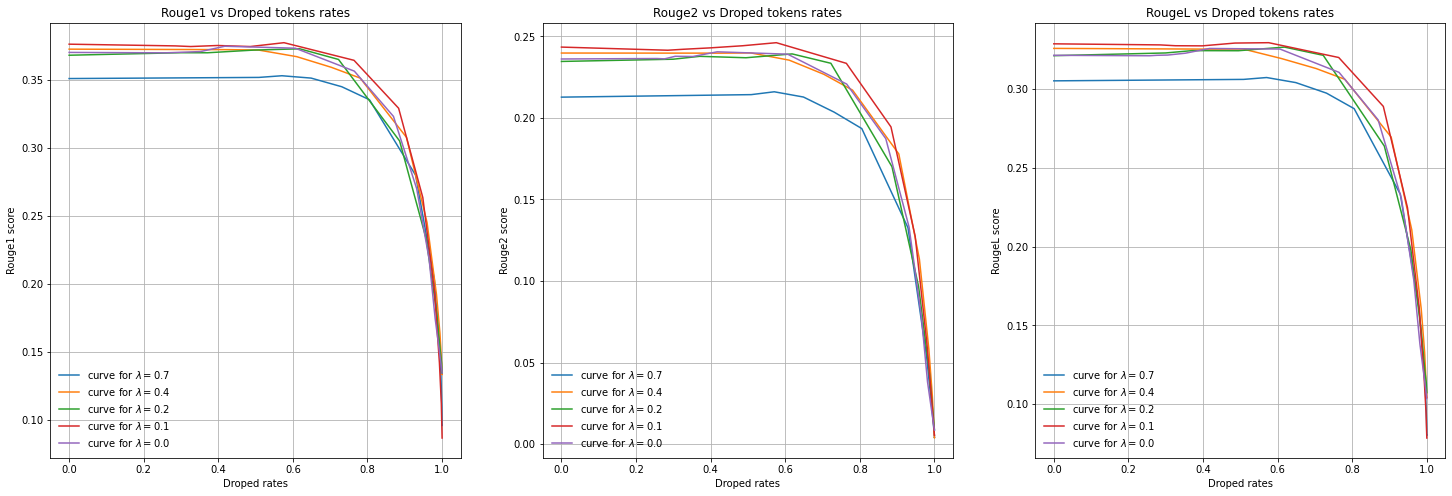

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(25, 8))

axes[0].plot(dropped_rates7,r17,label=r'curve for $\lambda = 0.7$')
# axes[0].plot(dropped_rates6,r16,label=r'curve for $\lambda = 0.6$')
axes[0].plot(dropped_rates,r1,label=r'curve for $\lambda = 0.4$')
axes[0].plot(dropped_ratess,r12, label=r'curve for $\lambda = 0.2$')
axes[0].plot(dropped_rates1,r11,label=r'curve for $\lambda = 0.1$')
axes[0].plot(dropped_rates0,r10,label=r'curve for $\lambda = 0.0$')
axes[0].set_xlabel('Droped rates')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs Droped tokens rates")
axes[0].legend(frameon=False)
axes[0].grid(True)

axes[1].plot(dropped_rates7,r27, label=r'curve for $\lambda = 0.7$')
# axes[1].plot(dropped_rates6,r26, label=r'curve for $\lambda = 0.6$')
axes[1].plot(dropped_rates,r2, label=r'curve for $\lambda = 0.4$')
axes[1].plot(dropped_ratess,r22, label=r'curve for $\lambda = 0.2$')
axes[1].plot(dropped_rates1,r21,label=r'curve for $\lambda = 0.1$')
axes[1].plot(dropped_rates0,r20,label=r'curve for $\lambda = 0.0$')
axes[1].set_xlabel('Droped rates')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs Droped tokens rates")
axes[1].legend(frameon=False)
axes[1].grid(True)

axes[2].plot(dropped_rates7,rL7, label=r'curve for $\lambda = 0.7$')
# axes[2].plot(dropped_rates6,rL6, label=r'curve for $\lambda = 0.6$')
axes[2].plot(dropped_rates,rL, label=r'curve for $\lambda = 0.4$')
axes[2].plot(dropped_ratess,rL2, label=r'curve for $\lambda = 0.2$')
axes[2].plot(dropped_rates1,rL1,label=r'curve for $\lambda = 0.1$')
axes[2].plot(dropped_rates0,rL0,label=r'curve for $\lambda = 0.0$')
axes[2].set_xlabel('Droped rates')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs Droped tokens rates")
axes[2].legend(frameon=False)
axes[2].grid(True)

# plt.savefig('/content/drive/MyDrive/images/new_same_gate_all_models_droprate0.0-7.png')

In [ ]:
test = valid_processed_data[valid_processed_data['article_len'] == 100]
inputex = tokenizer.batch_encode_plus(['summarize: ' + test.text.iloc[0] + ' </s>', 'summarize: ' + test.text.iloc[1] + ' </s>', 'summarize: ' + test.text.iloc[2] + ' </s>', 'summarize: ' + test.text.iloc[3] + ' </s>', 'summarize: ' + test.text.iloc[4] + ' </s>'], max_length= 100,padding=True,truncation=True,return_tensors='pt')
targetx = tokenizer.batch_encode_plus(['<pad> ' + test.summary.iloc[0] + ' </s>', '<pad> ' + test.summary.iloc[1] + ' </s>', '<pad> ' + test.summary.iloc[2] + ' </s>', '<pad> ' + test.summary.iloc[3] + ' </s>', '<pad> ' + test.summary.iloc[4] + ' </s>'], max_length= 50,padding=True, truncation=True,return_tensors='pt')

input_ids = inputex['input_ids']
attention_mask = inputex['attention_mask']
encoder = model.encoder
encoder = encoder.to(device).eval()
enc_out = encoder(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
g = enc_out[-1].squeeze(-1).squeeze(0).cpu().detach().numpy().squeeze()


In [ ]:
dec = []
for i in range(input_ids.shape[0]):
  dec_i = []
  for t in input_ids[i]:
    s = tokenizer.convert_ids_to_tokens(ids=t.item(), skip_special_tokens=True)
    dec_i.append(s)
  dec.append(dec_i)
dec_text = np.array(dec)#.squeeze()

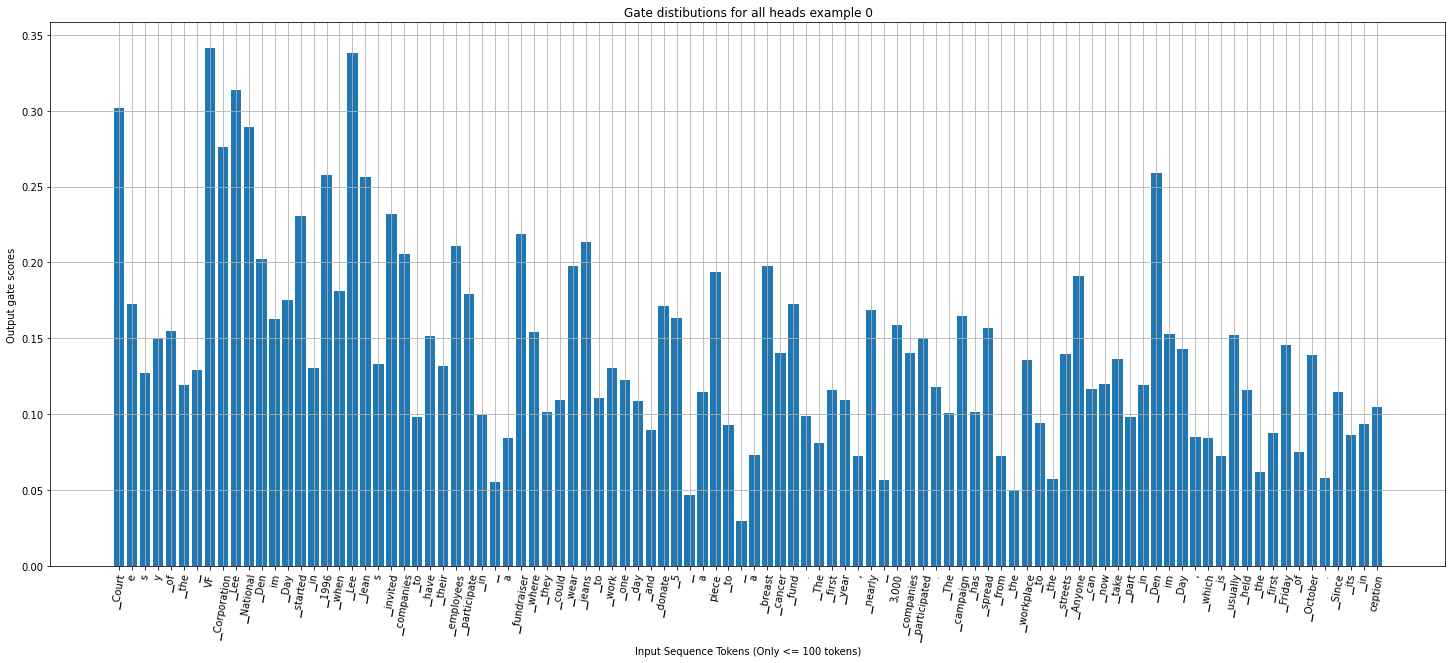

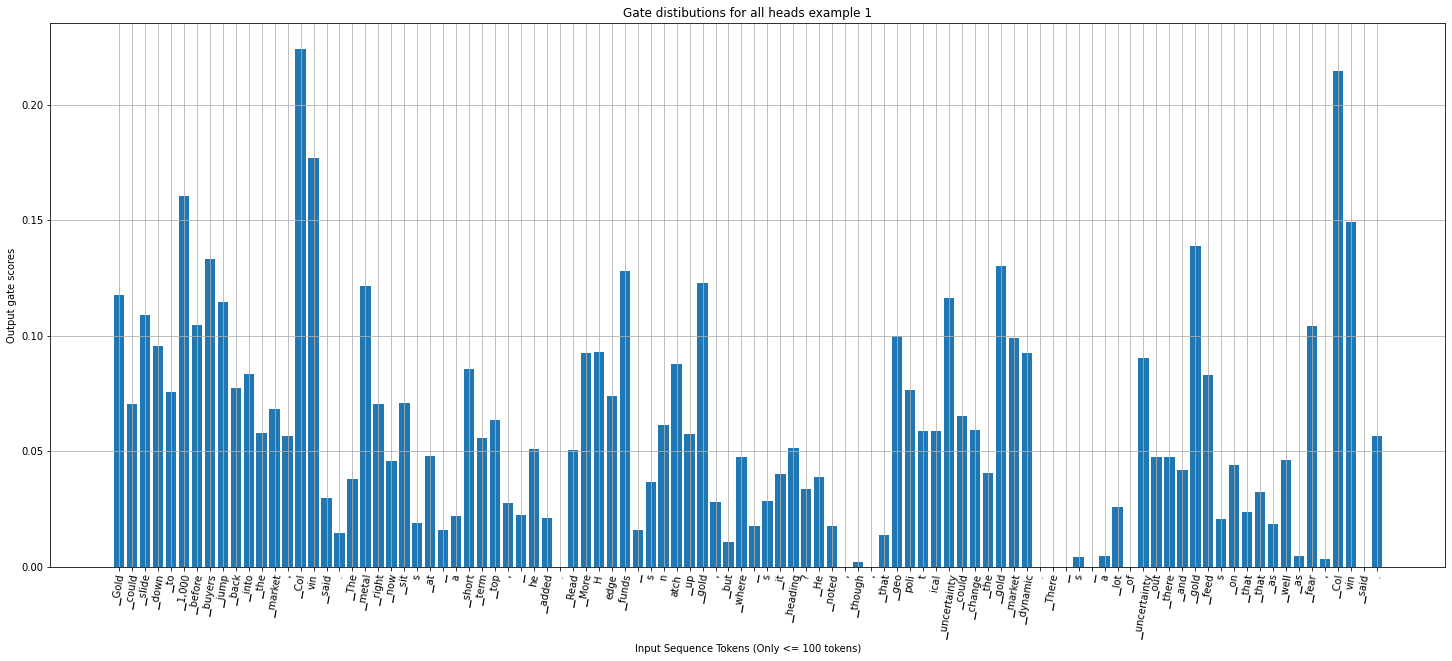

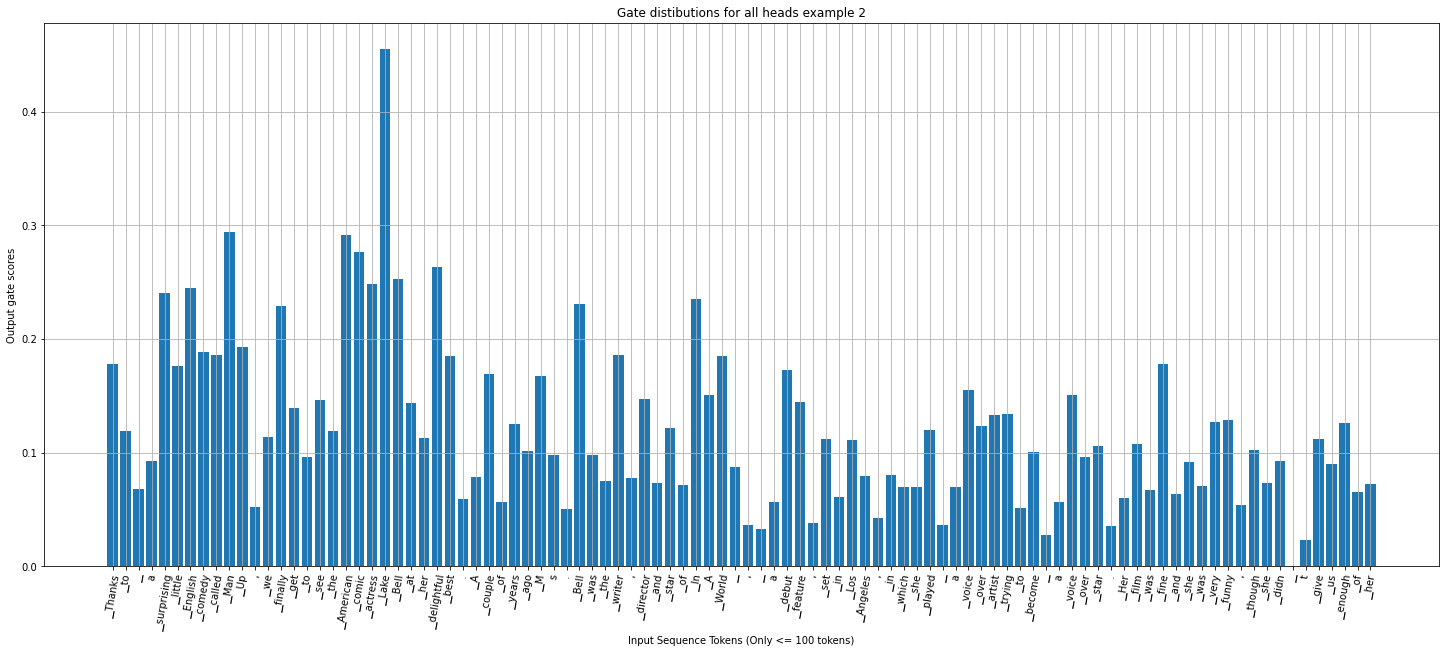

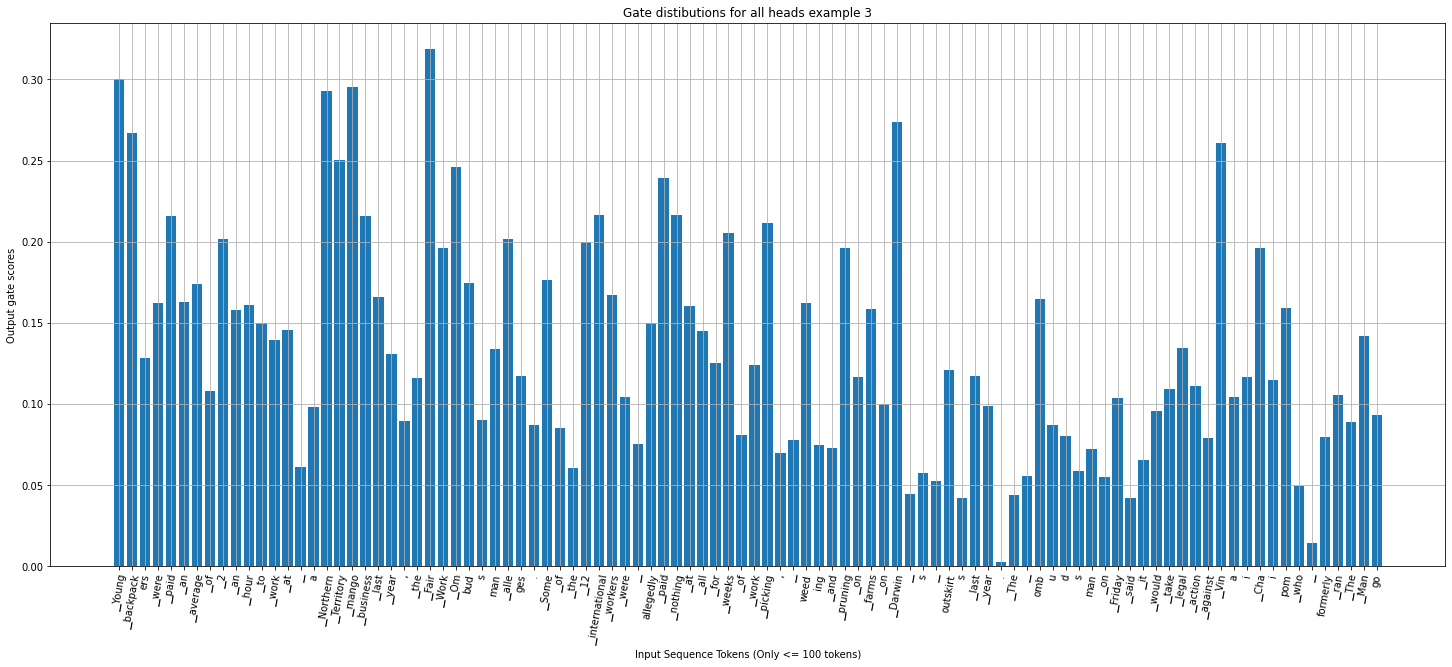

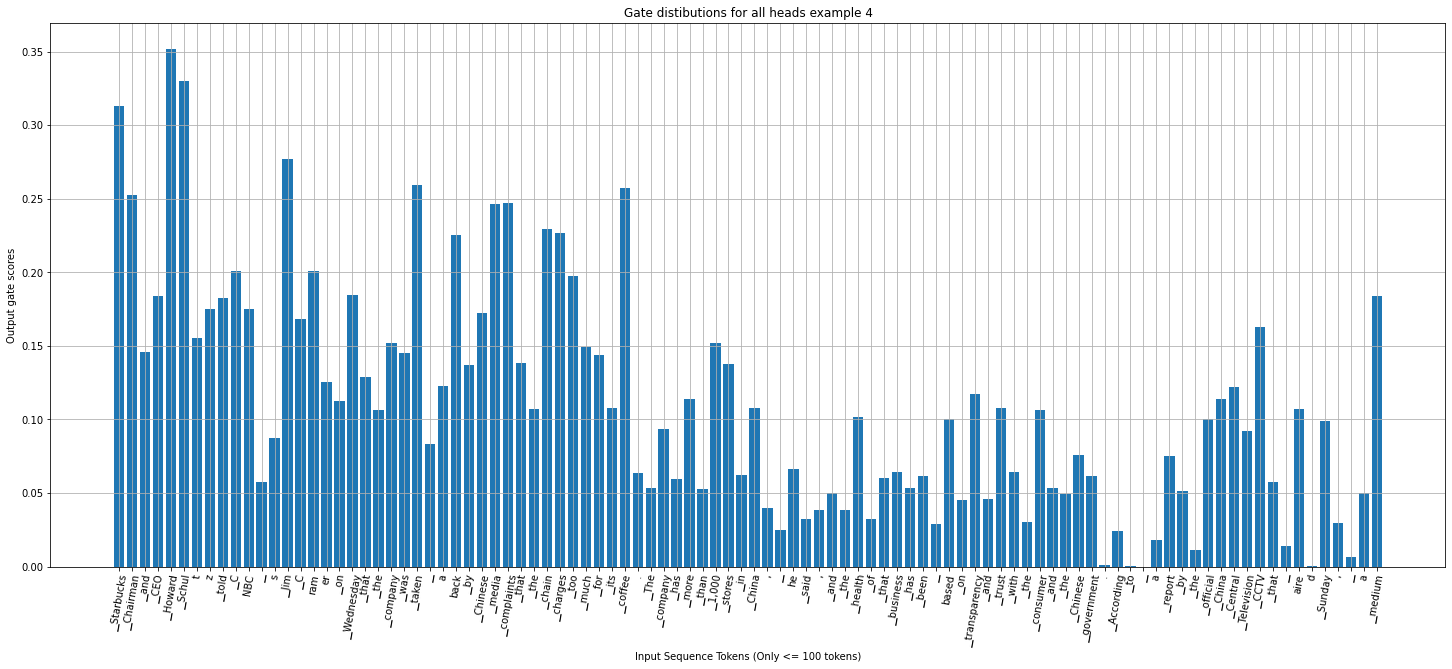

In [ ]:
import matplotlib.pyplot as plt

for i in range(input_ids.shape[0]):
    my_xticks = tuple(dec_text[i][2:])
    x = np.arange(len(my_xticks))
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    plt.bar(x,g[i][2:])
    plt.xticks(x, my_xticks, rotation=80)
    ax.set_xlabel('Input Sequence Tokens (Only <= 100 tokens)')
    ax.set_ylabel('Output gate scores')
    ax.set_title(f'Gate distibutions for all heads example {i}')
    plt.grid()
    # plt.savefig(f'/content/drive/MyDrive/images/new_same_gate_exemples_{i}{t5config.reg}.png')

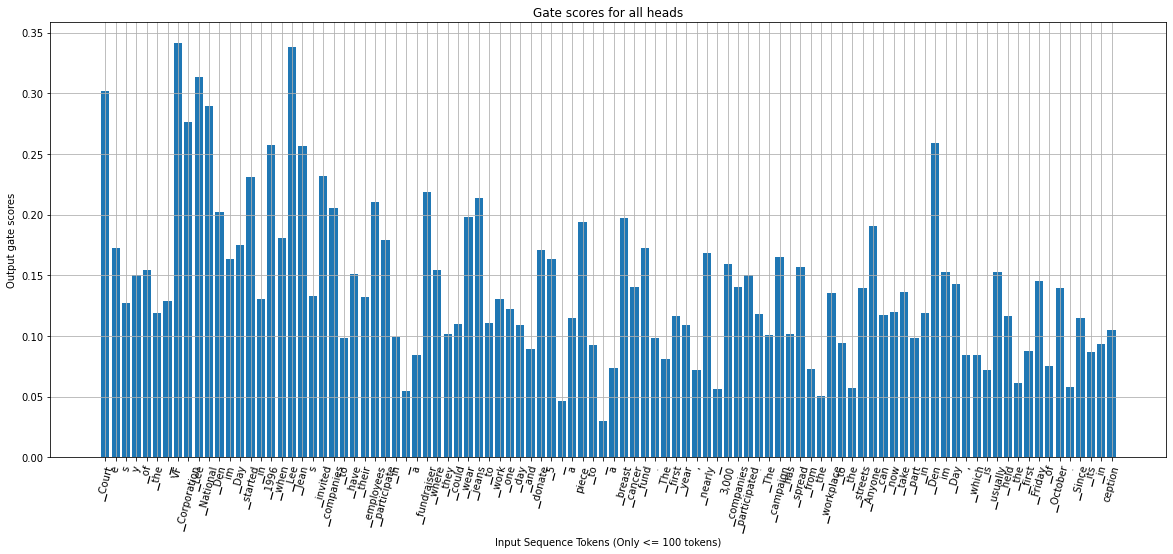

In [ ]:
# for idx in range(dec_text.shape[0]):

my_xticks = tuple(dec_text[0][2:])
x = np.arange(len(my_xticks))
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.bar(x,g[0][2:])
plt.xticks(x, my_xticks, rotation=75)
ax.set_xlabel('Input Sequence Tokens (Only <= 100 tokens)')
ax.set_ylabel('Output gate scores')
ax.set_title(f'Gate scores for all heads')
plt.grid()
# plt.savefig('/content/drive/MyDrive/images/test_same_gate_exemple.png')

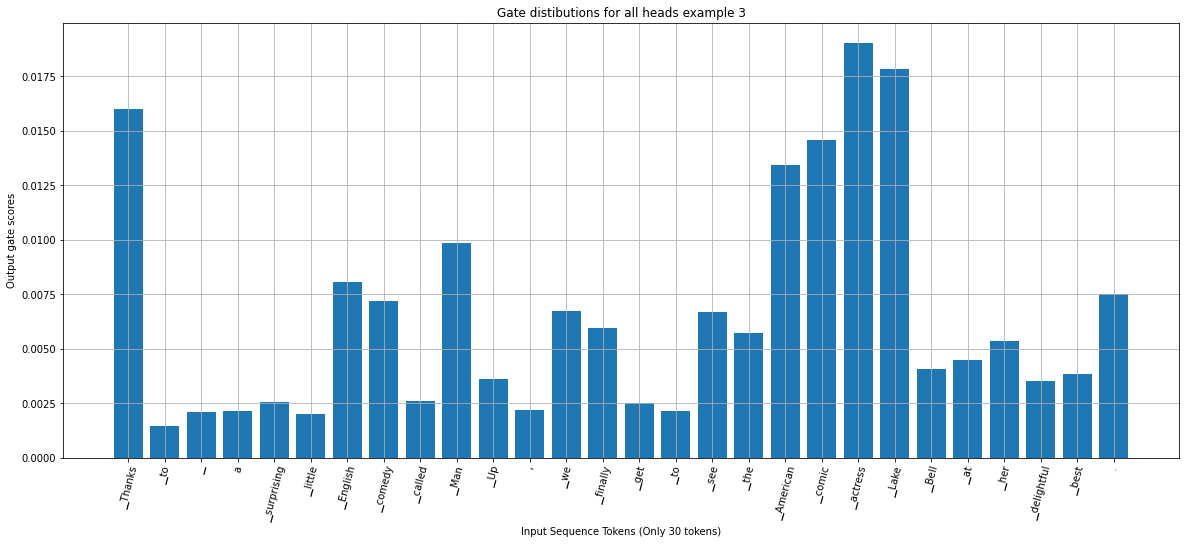

In [ ]:
# for idx in range(dec_text.shape[0]):

my_xticks = tuple(dec_text[2][2:])
x = np.arange(len(my_xticks))
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.bar(x,g[2][2:])
plt.xticks(x, my_xticks, rotation=75)
ax.set_xlabel('Input Sequence Tokens (Only 30 tokens)')
ax.set_ylabel('Output gate scores')
ax.set_title(f'Gate distibutions for all heads example {idx}')
plt.grid()
# plt.savefig('/content/drive/MyDrive/images/same_gate_exemples.png')

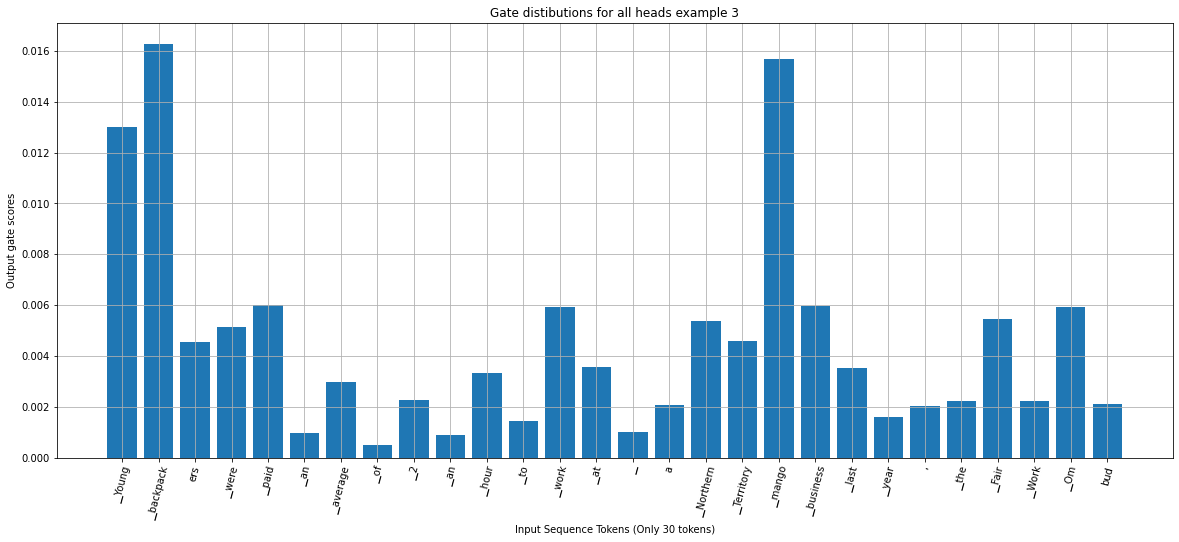

In [ ]:
# for idx in range(dec_text.shape[0]):

my_xticks = tuple(dec_text[3][2:])
x = np.arange(len(my_xticks))
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.bar(x,g[3][2:])
plt.xticks(x, my_xticks, rotation=75)
ax.set_xlabel('Input Sequence Tokens (Only 30 tokens)')
ax.set_ylabel('Output gate scores')
ax.set_title(f'Gate distibutions for all heads example {idx}')
plt.grid()
# plt.savefig('/content/drive/MyDrive/images/same_gate_exemples.png')

# **END HERE!!!**


---



---



---




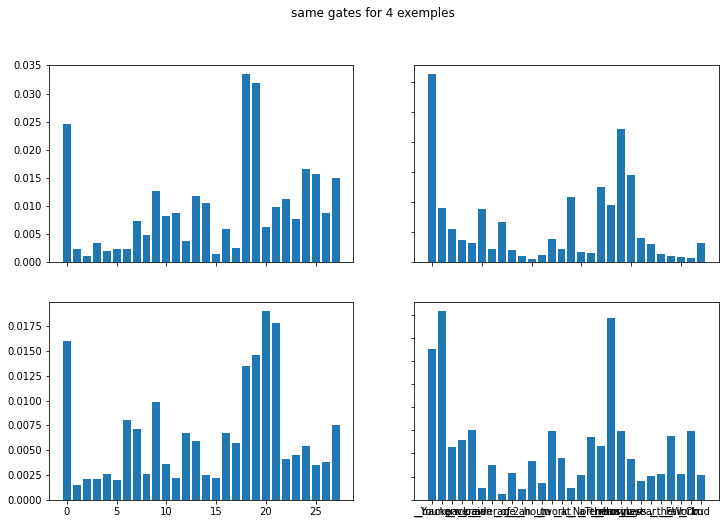

In [ ]:
my_xticks0 = tuple(dec_text[0][2:])
x0 = np.arange(len(my_xticks0))
gate0 = g[0][2:]

my_xticks1 = tuple(dec_text[1][2:])
x1 = np.arange(len(my_xticks1))
gate1 = g[1][2:]

my_xticks2 = tuple(dec_text[2][2:])
x2 = np.arange(len(my_xticks2))
gate2 = g[2][2:]

my_xticks3 = tuple(dec_text[3][2:])
x3 = np.arange(len(my_xticks3))
gate3 = g[3][2:]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('same gates for 4 exemples')
ax1.bar(x0, gate0)
plt.xticks(x0,my_xticks0)

ax2.bar(x1, gate1)
plt.xticks(x1, my_xticks1)

ax3.bar(x2, gate2)
plt.xticks(x2, my_xticks2)

ax4.bar(x3, gate3)
plt.xticks(x3, my_xticks3)


# for ax in axs.get_axes:
#     ax.set(xlabel='x-label', ylabel='y-label')

for ax in fig.get_axes():
    ax.label_outer()

# **For test data**

#### **When model trained with regularizer ($\lambda$ = 0.4)**


In [ ]:
score_dict, result_dict, valid_tokens_info_dict, gates_val_output = get_scores_experiment(model, test_loader, t5config, thresholds)

In [ ]:
score_dict

{'scores_on_threshold_-1.0': {'rouge1': 0.3703892944496688,
  'rouge2': 0.22200634982705192,
  'rougeL': 0.3219183830139305},
 'scores_on_threshold_0.001': {'rouge1': 0.3692160258311524,
  'rouge2': 0.21777124964862918,
  'rougeL': 0.3187990877562419},
 'scores_on_threshold_0.002': {'rouge1': 0.36429351369112145,
  'rouge2': 0.2070571150473919,
  'rougeL': 0.3136200465926896},
 'scores_on_threshold_0.003': {'rouge1': 0.35702458659979114,
  'rouge2': 0.19068223621511232,
  'rougeL': 0.30117564766757615},
 'scores_on_threshold_0.004': {'rouge1': 0.340918711773201,
  'rouge2': 0.16999852129962334,
  'rougeL': 0.28302796360733357},
 'scores_on_threshold_0.005': {'rouge1': 0.3252240598923838,
  'rouge2': 0.15000250896635614,
  'rougeL': 0.2652770245722331},
 'scores_on_threshold_0.006': {'rouge1': 0.31676988683544244,
  'rouge2': 0.13459267693872706,
  'rougeL': 0.2525855077616617},
 'scores_on_threshold_0.007': {'rouge1': 0.3049391113276665,
  'rouge2': 0.12087154460982338,
  'rougeL': 0.2

In [ ]:
valid_tokens_info_dict

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(570307., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.001': (tensor(209143., device='cuda:0'),
  tensor(361164., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.002': (tensor(321557., device='cuda:0'),
  tensor(248750., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.003': (tensor(384913., device='cuda:0'),
  tensor(185394., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.004': (tensor(425129., device='cuda:0'),
  tensor(145178., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.005': (tensor(453003., device='cuda:0'),
  tensor(117304., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.006': (tensor(473170., device='cuda:0'),
  tensor(97137., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.0

In [ ]:
thresholds[0] = 0.0

rouge1 = []
rouge2 = []
rougeL = []
dropped = []
nonzerostokens = []
totaltokens = []
retained_rate = []
dropped_rates = []
gates_sum = []

for thr, thr_t in zip(score_dict.keys(), valid_tokens_info_dict.keys()):
    
    rouge1.append(score_dict[thr]['rouge1'])
    rouge2.append(score_dict[thr]['rouge2'])
    rougeL.append(score_dict[thr]['rougeL'])
    
    dropped.append(valid_tokens_info_dict[thr_t][0])
    nonzerostokens.append(valid_tokens_info_dict[thr_t][1])
    totaltokens.append(valid_tokens_info_dict[thr_t][-1])
    drop_rate = valid_tokens_info_dict[thr_t][1].item()/valid_tokens_info_dict[thr_t][-1].item()
    dropped_rates.append(1-drop_rate)
    retained_rate.append(drop_rate)
for thr in gates_val_output.keys():
  gates_sum.append(gates_val_output[thr])



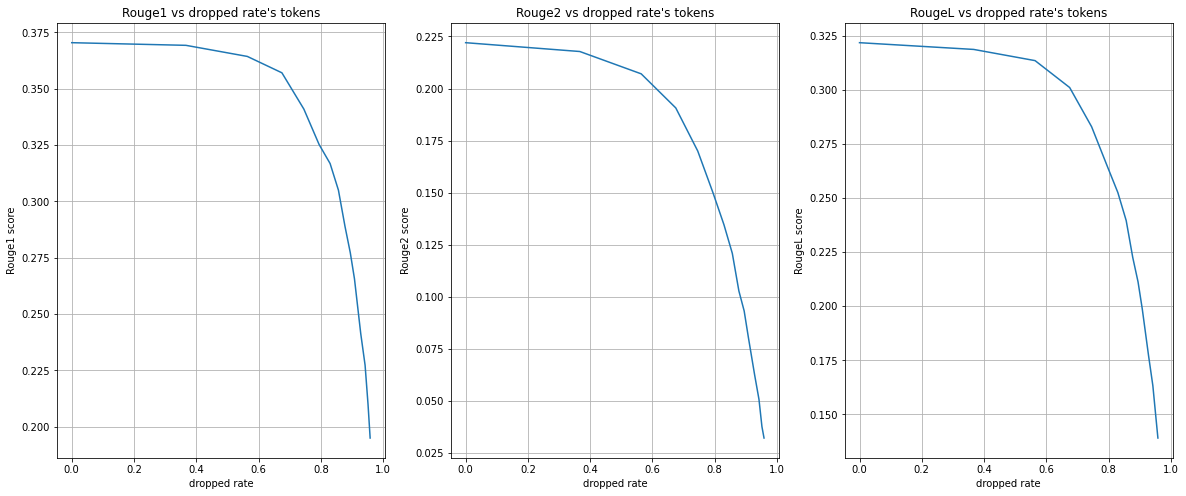

In [ ]:
import matplotlib.pyplot as plt

rouge11 = np.array(rouge1)
rouge22 = np.array(rouge2)
rougeLL = np.array(rougeL)

rate1 = np.array(dropped_rates)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(rate1,rouge11, 'o-')
axes[0].set_xlabel('dropped rate')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs dropped rate's tokens")
axes[0].grid(True)

axes[1].plot(rate1,rouge22, 'o-')
#axes[1].axis('tight')
axes[1].set_xlabel('dropped rate')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs dropped rate's tokens")
axes[1].grid(True)

axes[2].plot(rate1,rougeLL, 'o-')
axes[2].set_xlabel('dropped rate')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs dropped rate's tokens");
axes[2].grid(True)

plt.savefig('/content/drive/MyDrive/images/test_alldroprate0.4.png')

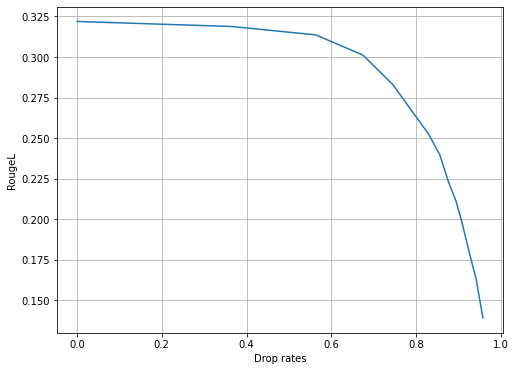

In [ ]:
plt.figure(figsize=(8, 6))
aa = np.array(dropped_rates)
rr = np.array(rougeL)
plt.plot(aa,rr)
plt.xlabel('Drop rates')
plt.ylabel('RougeL')
plt.grid()
plt.savefig('/content/drive/MyDrive/images/test_data_same_gates_rougeL0.4.png')

In [ ]:
get_metric(rouge1, rouge2, rougeL, dropped_rates, retained_rate, valid_tokens_info_dict, thresholds, t5config, 0.003,name_data='new_model_test', path=None)

### **When model trained with regularizer ($\lambda$ = 0.2)**


In [ ]:
thresholds[0] = -1.0

In [ ]:
score_dictt, result_dictt, valid_tokens_info_dictt, gates_val_outputt = get_scores_experiment(model, test_loader, t5config, thresholds)

125it [05:38,  2.71s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=1.52]

Threshold: -1.0 | Threshold Time: 6m 32s



125it [05:40,  2.72s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=1.55]

Threshold: 0.001 | Threshold Time: 6m 34s



125it [05:40,  2.73s/it]
100%|██████████| 125/125 [00:52<00:00,  2.37it/s, loss=1.65]

Threshold: 0.002 | Threshold Time: 6m 34s



125it [05:40,  2.72s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=1.78]

Threshold: 0.003 | Threshold Time: 6m 34s



125it [05:51,  2.81s/it]
100%|██████████| 125/125 [00:52<00:00,  2.37it/s, loss=1.9]

Threshold: 0.004 | Threshold Time: 6m 45s



125it [05:48,  2.79s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.01]

Threshold: 0.005 | Threshold Time: 6m 42s



125it [05:42,  2.74s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.12]

Threshold: 0.006 | Threshold Time: 6m 36s



125it [05:41,  2.73s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.21]

Threshold: 0.007 | Threshold Time: 6m 35s



125it [05:38,  2.71s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.3]

Threshold: 0.008 | Threshold Time: 6m 32s



125it [05:33,  2.67s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.4]

Threshold: 0.009 | Threshold Time: 6m 27s



125it [05:32,  2.66s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.48]

Threshold: 0.01 | Threshold Time: 6m 26s



125it [05:45,  2.76s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.63]

Threshold: 0.012 | Threshold Time: 6m 39s



125it [05:56,  2.85s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.77]

Threshold: 0.014 | Threshold Time: 6m 50s



125it [05:58,  2.87s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=2.9]

Threshold: 0.016 | Threshold Time: 6m 52s



125it [06:01,  2.89s/it]
100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=3.01]

Threshold: 0.018 | Threshold Time: 6m 55s
End Experiments !!!


In [ ]:
score_dictt

{'scores_on_threshold_-1.0': {'rouge1': 0.36353471380813795,
  'rouge2': 0.21458842080336799,
  'rougeL': 0.3118440377691638},
 'scores_on_threshold_0.001': {'rouge1': 0.36310128203109115,
  'rouge2': 0.21296677499930206,
  'rougeL': 0.3113026472597883},
 'scores_on_threshold_0.002': {'rouge1': 0.3619355165596712,
  'rouge2': 0.2117237503732116,
  'rougeL': 0.31084479453574343},
 'scores_on_threshold_0.003': {'rouge1': 0.35511203673912073,
  'rouge2': 0.2032189127406857,
  'rougeL': 0.3036822341365568},
 'scores_on_threshold_0.004': {'rouge1': 0.35744900531153545,
  'rouge2': 0.20291608712284093,
  'rougeL': 0.3054483997770596},
 'scores_on_threshold_0.005': {'rouge1': 0.3565089026271004,
  'rouge2': 0.19684659401214363,
  'rougeL': 0.30171567569725677},
 'scores_on_threshold_0.006': {'rouge1': 0.35055485409058046,
  'rouge2': 0.18511885536421563,
  'rougeL': 0.2944916796431109},
 'scores_on_threshold_0.007': {'rouge1': 0.3503504513284292,
  'rouge2': 0.18221684160420012,
  'rougeL': 0

In [ ]:
valid_tokens_info_dictt

{'tonkens_wth_threshold_-1.0': (tensor(0., device='cuda:0'),
  tensor(570307., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.001': (tensor(80294., device='cuda:0'),
  tensor(490013., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.002': (tensor(175168., device='cuda:0'),
  tensor(395139., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.003': (tensor(243283., device='cuda:0'),
  tensor(327024., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.004': (tensor(293088., device='cuda:0'),
  tensor(277219., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.005': (tensor(331582., device='cuda:0'),
  tensor(238725., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.006': (tensor(361831., device='cuda:0'),
  tensor(208476., device='cuda:0'),
  tensor(570307., device='cuda:0')),
 'tonkens_wth_threshold_0.0

In [ ]:
rouge1t = []
rouge2t = []
rougeLt = []
droppedt = []
nonzerostokenst = []
totaltokenst = []
retained_ratet = []
dropped_ratest = []

for thrt, thr_tt in zip(score_dictt.keys(), valid_tokens_info_dictt.keys()):
    
    rouge1t.append(score_dictt[thrt]['rouge1'])
    rouge2t.append(score_dictt[thrt]['rouge2'])
    rougeLt.append(score_dictt[thrt]['rougeL'])
    
    droppedt.append(valid_tokens_info_dictt[thr_tt][0])
    nonzerostokenst.append(valid_tokens_info_dictt[thr_tt][1])
    totaltokenst.append(valid_tokens_info_dictt[thr_tt][-1])
    drop_ratet = valid_tokens_info_dictt[thr_tt][1].item()/valid_tokens_info_dictt[thr_tt][-1].item()
    dropped_ratest.append(1-drop_ratet)

    retained_ratet.append(drop_ratet)

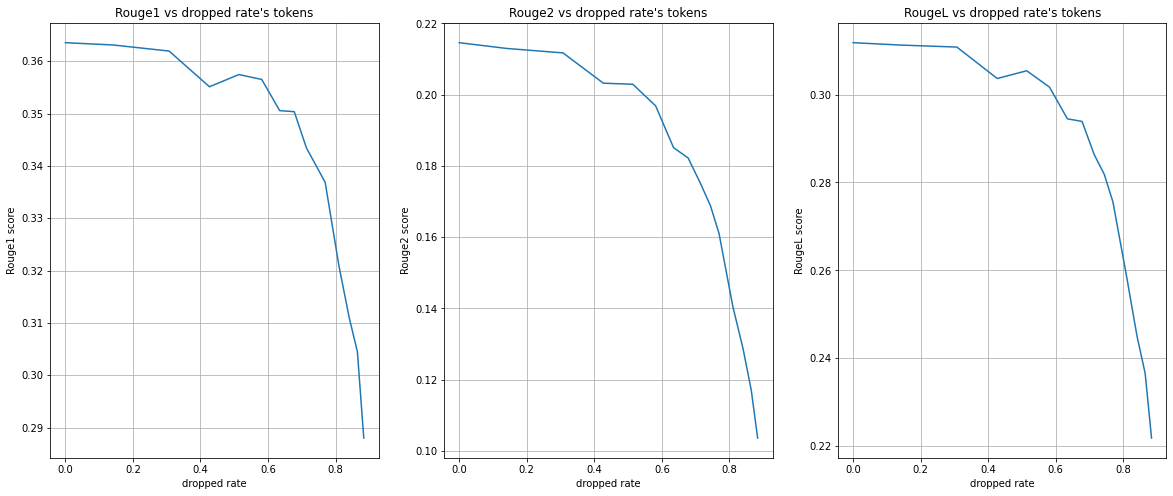

In [ ]:
import matplotlib.pyplot as plt

droprate1 = np.array(dropped_ratest)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].plot(droprate1,rouge1t)
axes[0].set_xlabel('dropped rate')
axes[0].set_ylabel('Rouge1 score')
axes[0].set_title("Rouge1 vs dropped rate's tokens")
axes[0].grid(True)

axes[1].plot(droprate1,rouge2t)
#axes[1].axis('tight')
axes[1].set_xlabel('dropped rate')
axes[1].set_ylabel('Rouge2 score')
axes[1].set_title("Rouge2 vs dropped rate's tokens")
axes[1].grid(True)

axes[2].plot(droprate1,rougeLt)
axes[2].set_xlabel('dropped rate')
axes[2].set_ylabel('RougeL score')
axes[2].set_title("RougeL vs dropped rate's tokens");
axes[2].grid(True)

plt.savefig('/content/drive/MyDrive/images/test_alldroprate0.2.png')

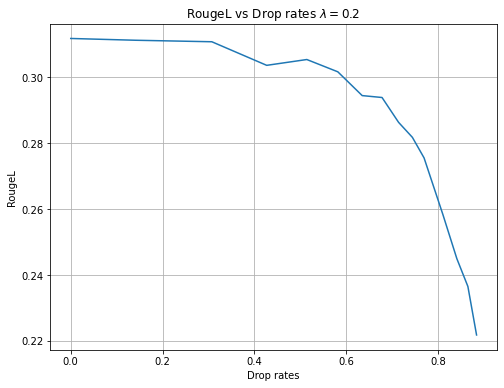

In [ ]:
plt.figure(figsize=(8, 6))
aa = np.array(dropped_ratest)
rr = np.array(rougeLt)
plt.plot(aa,rr)
plt.xlabel('Drop rates')
plt.ylabel('RougeL')
plt.title('RougeL vs Drop rates $\lambda = 0.2$')
plt.grid()
plt.savefig('/content/drive/MyDrive/images/test_data_same_gates_rougeL0.2.png')

In [ ]:
get_metric(rouge1t, dropped_ratest, retained_ratet, valid_tokens_info_dictt, thresholds, t5config, 0.003,name_data='test', path=path)

##### Visualizations of gates distribution and Attention layer

In [ ]:
test = test_processed_data[test_processed_data['article_len'] == 100]
inputex = tokenizer.batch_encode_plus(['summarize: ' + test.text.iloc[0] + ' </s>'], max_length= 30,truncation=True,return_tensors='pt')
targetx = tokenizer.batch_encode_plus(['<pad> ' + test.summary.iloc[0] + ' </s>'], max_length= 30,truncation=True,return_tensors='pt')
inputex, targetx

({'input_ids': tensor([[21603,    10, 24652,     9,  1925,     7,  2031,   263,   841,    46,
            462,    79,  2654,     3,    17,  9460,    11,    24,   568,    19,
              3,     7,    29, 14547,    53,    95,     8,   493,   208,  9807]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1]])},
 {'input_ids': tensor([[    0, 24652,     9,  1925,     7, 12406,   120,   263,   841,    46,
            462,    79,  2654,     3,    17,  9460,    11,    24,   568,    19,
              3,     7,    29, 14547,    53,    95,     8,   493,   208,  9807]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1]])})

In [ ]:
model = model.to(device)
model.eval()
enc = model.encoder
enc_out = enc(input_ids = inputex['input_ids'].to(device), attention_mask = inputex['attention_mask'].to(device))
enc_out[-1].shape

torch.Size([1, 1, 30, 1])

In [ ]:
g = enc_out[-1].squeeze(-1).squeeze(0).cpu().detach().numpy().squeeze()

decoded = [tokenizer.convert_ids_to_tokens(ids=i, skip_special_tokens=True) for i in inputex['input_ids']]
dec_text = np.array(decoded).squeeze()
dec_text, g

(array(['▁summarize', ':', '▁Tyr', 'a', '▁Bank', 's', '▁finally', '▁made',
        '▁someone', '▁an', '▁offer', '▁they', '▁couldn', '▁', 't',
        '▁refuse', '▁and', '▁that', '▁person', '▁is', '▁', 's', 'n',
        'atch', 'ing', '▁up', '▁the', '▁Be', 'v', '▁Hills'], dtype='<U10'),
 array([0.23999432, 0.23825403, 0.04139355, 0.00805494, 0.0097789 ,
        0.01315875, 0.00909746, 0.00991749, 0.00711741, 0.00382152,
        0.00436699, 0.00404455, 0.00475814, 0.00205237, 0.00122724,
        0.00247909, 0.00541401, 0.00250862, 0.00575773, 0.00408889,
        0.09740875, 0.00408525, 0.00733469, 0.0089306 , 0.00562254,
        0.00375731, 0.00579834, 0.01076342, 0.00661868, 0.00649879],
       dtype=float32))

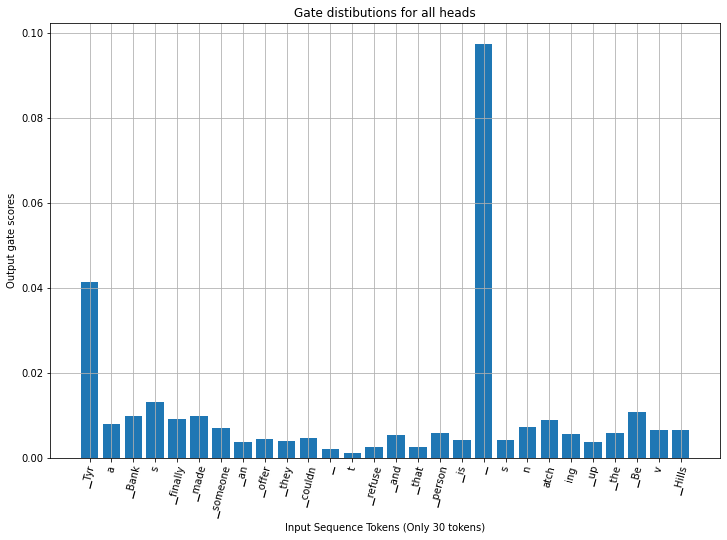

In [ ]:
import matplotlib.pyplot as plt

my_xticks = tuple(dec_text[2:])
x = np.arange(len(my_xticks))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.bar(x,g[2:])
plt.xticks(x, my_xticks, rotation=75)
ax.set_xlabel('Input Sequence Tokens (Only 30 tokens)')
ax.set_ylabel('Output gate scores')
ax.set_title('Gate distibutions for all heads')
plt.grid()

plt.savefig('/content/drive/MyDrive/images/test_same_gate_allheads_reg0.4.png')

## Visualize the cross-attention last layer

In [ ]:
input_ids = inputex['input_ids'].to(device)
attention_mask = inputex['attention_mask'].to(device)
target_labels = targetx['input_ids'].to(device)
# t5config.threshold = 0.5

out = model(input_ids = input_ids, attention_mask=attention_mask, decoder_input_ids=target_labels)

In [ ]:
def visual(model, seq_trg, seq_src, lay_num):
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    attention_map = model.decoder.block[lay_num].layer[1].EncDecAttention.o.weight.data[:len(seq_trg), :len(seq_src)]
    i = ax.imshow(attention_map.cpu(), interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Projector values)', labelpad=2)

    # add labels
    ax.set_yticks(range(len(seq_trg)))
    ax.set_yticklabels(seq_trg)

    ax.set_xticks(range(len(seq_src)))
    ax.set_xticklabels(seq_src, rotation=90)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()
    
    #plt.savefig(f'/content/drive/MyDrive/images/test_attnheads_reg0.2.png')

<Figure size 432x288 with 0 Axes>

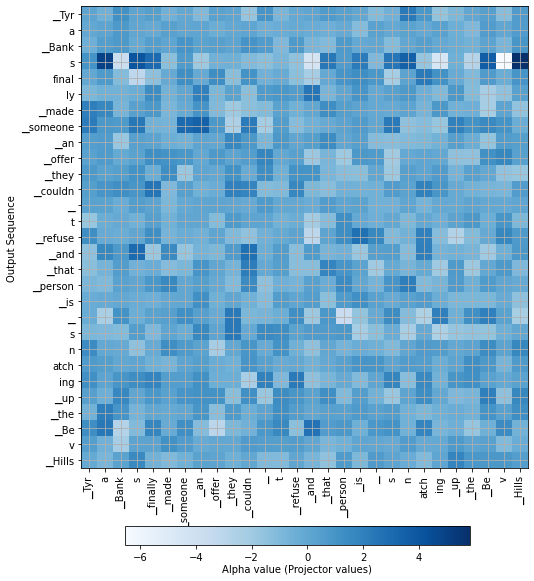

In [ ]:
import matplotlib.pyplot as plt

#src_sent = tokenizer.decode(token_ids=inputex['input_ids'].squeeze(), skip_special_tokens=True) # = test.text.iloc[0].split()
src_sent = [tokenizer.convert_ids_to_tokens(ids=i, skip_special_tokens=True) for i in inputex['input_ids']] # = test.text.iloc[0].split()
src_sent = np.array(src_sent).squeeze()[2:] #src_sent.split()
#tgt_sent = tokenizer.decode(token_ids=targetx['input_ids'].squeeze(), skip_special_tokens=True) # 
tgt_sent = [tokenizer.convert_ids_to_tokens(ids=i, skip_special_tokens=True) for i in targetx['input_ids']] # test.summary.iloc[0].split()
tgt_sent = np.array(tgt_sent).squeeze() # tgt_sent.split()

visual(model, tgt_sent, src_sent, 11)